# The Maximal Coverage Location Problem

Notebook adapted from [MCLP example](https://pysal.org/spopt/notebooks/mclp.html) in PySAL documentation.   
*Authors:* [Germano Barcelos](https://github.com/gegen07), [James Gaboardi](https://github.com/jGaboardi), [Levi J. Wolf](https://github.com/ljwolf), [Qunshan Zhao](https://github.com/qszhao)


### MLCP applied to Grunerlokka, Oslo, Norway
- **Original Settings** - Keeping settings close to original MCLP example in PySAL documentation. **(this notebook)**
- **Extension 1** - Keeping MLCP-algorithm, but tailoring placements and weights for police cars scenario.
- **Extension 2** - Probably defining custom MCLP-algorithm with PuLP for police cars scenario.
- **Extension 3** - Probably defining custom MCLP-algorithm with PuLP for police cars scenario (capacitated).

| Categories           | Original Settings    | (possible) Extension 1                           |
|----------------------|----------------------|---------------------------------------|
| **Objective function**| Maximize nodes covered  | same  |
| **Clients**          | Number = 100          | same                         |                                 |
|                      | Placement = randomly generated with `simulated_geo_points()` | Placement = evenly using a grid |
| **Facilities**       | Number = 4/10 candidates | Number = 3/10 candidates          |
|                      | Service radius = 1000m | Service radius = 1300m              |
|                      | Placement = randomly generated with `simulated_geo_points()` | Placement = manually pick 10 candidate points in OSM |
| **Client weights**   | Random weight in range [1,12] using `np.random.randint()` | Addresses(population proxy): Weight based on nr. of neighbor addresses within given range |
|                      |                                                             | Hotspot-variables (crime, traffic): Weight based on weighted distance to hotspot points. |


---

The objective of the LSCP is to minimize the number of candidate facility sites in a maximum service standard but therein arises another problem: the budget. Sometimes it requires many facility sites to achieve complete coverage, and there are circumstances when the resources are not available. Therefore, determining how much coverage can be achieved considering an exact number of facilities is highly beneficial. The MCLP class solves this problem: _Maximize the amount of demand covered within a maximal service distance or time standard by locating a fixed number of facilities_.

**MCLP in math notation:**

**Maximize:**
- $ \sum_{i \in I} a_i X_i $

**Subject to:**
- $ \sum_{j \in N_i} Y_j \geq X_i \quad \forall i \in I $
- $ \sum_{j \in J} Y_j = p $
- $ X_i \in \{0, 1\} \quad \forall i \in I $
- $ Y_j \in \{0, 1\} \quad \forall j \in J $

**Where:**

- $i$ = index referencing nodes of the network as demand
- $j$ = index referencing nodes of the network as potential facility sites
- $S$ = maximal acceptable service distance or time standard
- $d_{i,j}$ = shortest distance or travel time between nodes $i$ and $j$
- $N_i$ = $j | d_{ij} \leq S$ 
- $p$ = number of facilities to be located
- $Y_j$ =
  - 1, if a facility is located at node $j$
  - 0, otherwise
- $X_i$ =
  - 1, if demand $i$ is covered within a service standard
  - 0, otherwise

  
_This excerpt above is adapted from Church and Murray (2018)._

This tutorial generates synthetic demand (clients) and facility sites near a 10x10 lattice representing a gridded urban core. Three MCLP instances are solved while varying parameters:

* `MCLP.from_cost_matrix()` with network distance as the metric
* `MCLP.from_geodataframe()` with euclidean distance as the metric
* `MCLP.from_geodataframe()` with predefined facility locations and euclidean distance as the metric

In [182]:
%config InlineBackend.figure_format = "retina"
%load_ext watermark
%watermark

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Last updated: 2024-02-26T20:19:33.975892+01:00

Python implementation: CPython
Python version       : 3.11.6
IPython version      : 8.16.0

Compiler    : MSC v.1935 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 158 Stepping 10, GenuineIntel
CPU cores   : 12
Architecture: 64bit



In [183]:
# imports for osmnx
import networkx as nx
import osmnx as ox
import geopandas as gpd
import pandas as pd
from shapely.geometry import Polygon
from shapely.ops import unary_union

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

%matplotlib inline

In [184]:
# imports for MCLP with spopt, etc.
# import geopandas
# import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import matplotlib.lines as mlines
import numpy as np
import pulp
import shapely
import spopt
from spopt.locate import MCLP, simulated_geo_points 

import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    # ignore deprecation warning - GH pysal/spaghetti#649
    import spaghetti

%watermark -w
%watermark -iv

Watermark: 2.4.3

matplotlib: 3.8.0
networkx  : 3.2.1
pulp      : 2.7.0
osmnx     : 1.7.1
geopandas : 0.14.0
spopt     : 0.5.0
spaghetti : 1.7.4
numpy     : 1.24.4
pandas    : 2.1.2
shapely   : 2.0.2



## 0. Population data
Loading population data in 250x250m grid cells for Oslo, Norway.

In [185]:
# load geopandas dataframe of population data
oslo_population_geojson = "C:/Users/torha/prog.div/PiT/LinearProgramming/input_datasets/Oslo_pop2023_250m_wgs84_epsg4326_geojson/oslo_pop2023_250m_wgs84_epsg4326.geojson"
oslo_population = gpd.read_file(oslo_population_geojson)

# rename column names
oslo_population.columns = ['id', 'population', 'geometry']

# statistics of population data
print("Population statistics:\n", oslo_population['population'].describe())
print(type(oslo_population))
oslo_population.head()

# visualize population data on map
# oslo_population.plot(column='population', cmap='viridis', legend=True, figsize=(10,10))
# plt.title('Population in Oslo'); plt.show()

Population statistics:
 count    2380.000000
mean      297.201261
std       342.589174
min         1.000000
25%        59.000000
50%       211.000000
75%       369.000000
max      2351.000000
Name: population, dtype: float64
<class 'geopandas.geodataframe.GeoDataFrame'>


id  population  \
0  22637506643000          14   
1  22640006643000         177   
2  22642506643000         169   
3  22645006643000         261   
4  22647506643000         106   

                                            geometry  
0  MULTIPOLYGON (((10.78520 59.85702, 10.78075 59...  
1  MULTIPOLYGON (((10.78965 59.85717, 10.78520 59...  
2  MULTIPOLYGON (((10.79410 59.85731, 10.78965 59...  
3  MULTIPOLYGON (((10.79855 59.85745, 10.79410 59...  
4  MULTIPOLYGON (((10.80300 59.85759, 10.79855 59...

After inspection, we see the population ranges from 1 to 2351 in the 250x250m grid cells, in Oslo, Norway.

## 1. OSMnx and NetworkX
Loading a small road network of Grünerløkka for testing.

In [186]:
# Road network file path
# gruner_filepath = "C:/Users/torha/prog.div/PiT/osmnx-oslo/data/grünerlokka_road_network.gpkg"
gruner_filepath = "C:/Users/torha/prog.div/PiT/osmnx-oslo/data/grünerlokka_road_network.graphml"

type of gruner_graph: <class 'networkx.classes.multidigraph.MultiDiGraph'>
crs of gruner_graph:  epsg:4326


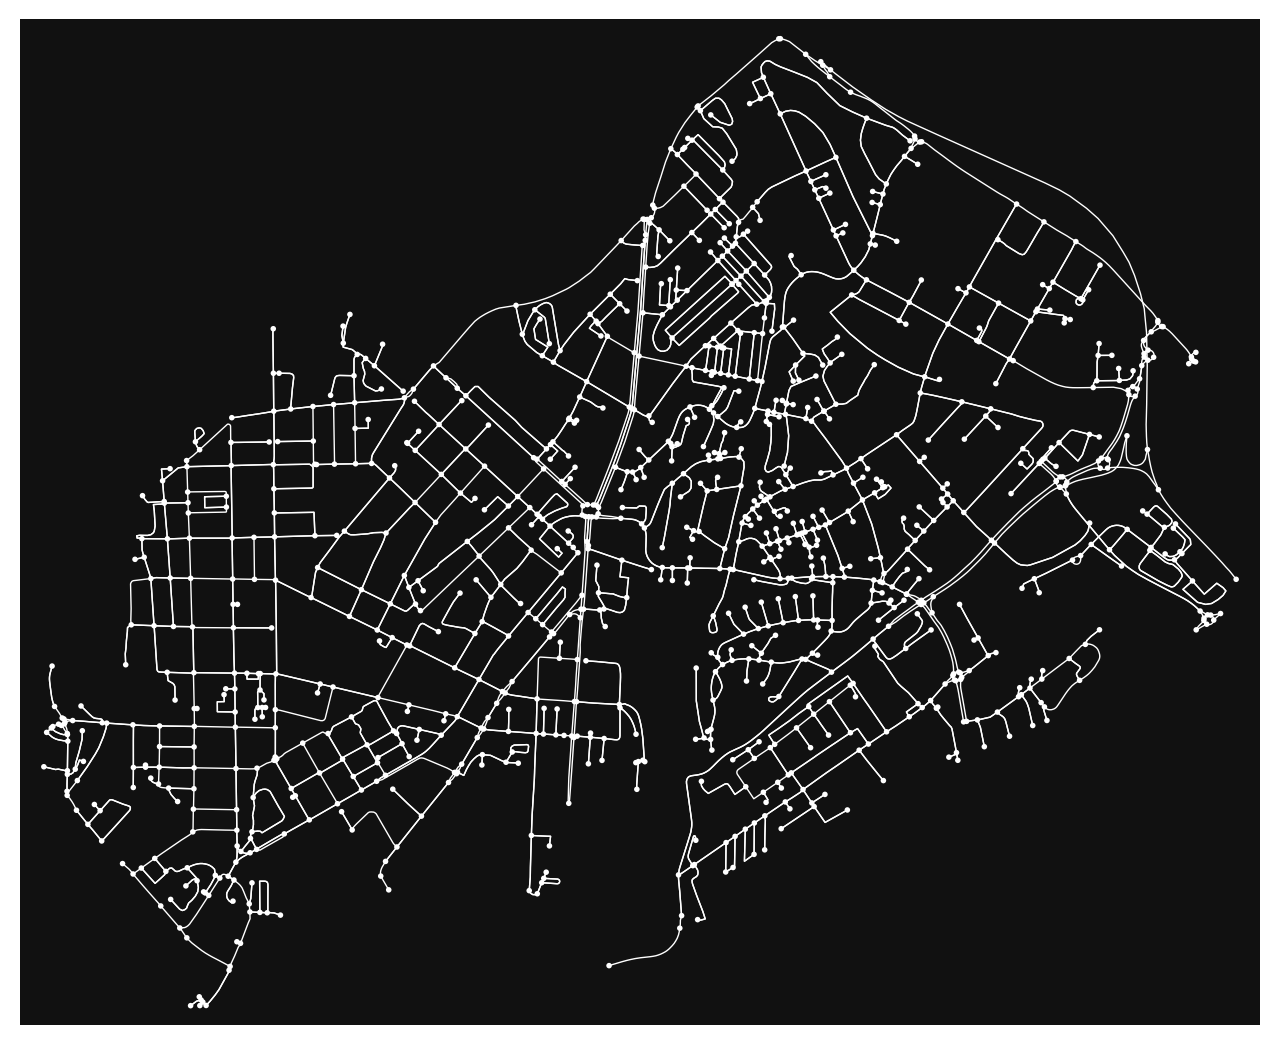

In [187]:
# Fetching network from OSM
# gruner_graph = ox.graph_from_place('Grünerløkka, Oslo, Norway', network_type="drive_service") # to fetch directly from OSM

# load the network as NetworkX MultiDiGraph object - using osmnx (Recommended)
gruner_graph = ox.load_graphml(gruner_filepath)
print(f"type of gruner_graph: {type(gruner_graph)}")
print(f"crs of gruner_graph:  {gruner_graph.graph['crs']}")

# plot graph
fig, ax = ox.plot_graph(gruner_graph, node_size=4, edge_linewidth=0.5, edge_color="w")

Successfully imported road network of Grünerløkka, Oslo, Norway in Coordinate system (CRS) WGS84, EPSG:4326.

In [188]:
# we can convert the graph network to node and edge GeoPandas GeoDataFrames
gruner_gdf_nodes, gruner_gdf_edges = ox.graph_to_gdfs(gruner_graph)
print(f"type of gruner_gdf_nodes:{type(gruner_gdf_nodes)}")
gruner_gdf_nodes.head()

type of gruner_gdf_nodes:<class 'geopandas.geodataframe.GeoDataFrame'>


y          x  street_count          highway  ref  \
osmid                                                             
79448  59.921558  10.750823             3              NaN  NaN   
79465  59.928495  10.761100             4  traffic_signals  NaN   
79475  59.928343  10.759132             3  traffic_signals  NaN   
79476  59.928694  10.764892             4  traffic_signals  NaN   
79490  59.929560  10.768588             5  traffic_signals  NaN   

                        geometry  
osmid                             
79448  POINT (10.75082 59.92156)  
79465  POINT (10.76110 59.92850)  
79475  POINT (10.75913 59.92834)  
79476  POINT (10.76489 59.92869)  
79490  POINT (10.76859 59.92956)

In [189]:
gruner_gdf_edges.head()

osmid lanes           name    highway  \
u     v          key                                                           
79448 3165357950 0                 129061337     2  Maridalsveien  secondary   
79465 106183     0                   4211442     2    Toftes gate  secondary   
      12630987   0                 349267814     2    Toftes gate  secondary   
      79475      0    [882463938, 337073150]     3     Sannergata   tertiary   
      12630988   0                 882463954     3     Sannergata   tertiary   

                      oneway reversed   length  \
u     v          key                             
79448 3165357950 0     False    False  107.935   
79465 106183     0     False     True  139.757   
      12630987   0     False    False   99.113   
      79475      0     False     True  111.025   
      12630988   0     False    False   44.617   

                                                               geometry  \
u     v          key                                                      
79448 3165357950 0    LINESTRING (10.75082 59.92156, 10.75078 59.921...   
79465 106183     0    LINESTRING (10.76110 59.92850, 10.76110 59.928...   
      12630987   0    LINESTRING (10.76110 59.92850, 10.76110 59.928...   
      79475      0    LINESTRING (10.76110 59.92850, 10.76107 59.928...   
      12630988   0    LINESTRING (10.76110 59.92850, 10.76113 59.928...   

                     maxspeed  ref junction bridge service width access tunnel  
u     v          key                                                            
79448 3165357950 0        NaN  NaN      NaN    NaN     NaN   NaN    NaN    NaN  
79465 106183     0        NaN  NaN      NaN    NaN     NaN   NaN    NaN    NaN  
      12630987   0         40  NaN      NaN    NaN     NaN   NaN    NaN    NaN  
      79475      0         40  NaN      NaN    NaN     NaN   NaN    NaN    NaN  
      12630988   0         40  NaN      NaN    NaN     NaN   NaN    NaN    NaN

In [190]:
# Reproject to a suitable projected CRS
gruner_gdf_edges_projected = gruner_gdf_edges.to_crs(epsg=32633)
streets = gruner_gdf_edges_projected
print(type(streets))

<class 'geopandas.geodataframe.GeoDataFrame'>


## 1.5 Simulate denmand nodes (events)
Task: add/simulate points (events police have to respond to) based on my population layer of 250x250m gridcells.

In [226]:
from shapely.geometry import Point, box
from shapely.ops import nearest_points

# Create a bounding box around the Grunerløkka road network
gruner_bbox = gruner_gdf_edges.total_bounds
gruner_area_polygon = gpd.GeoSeries(box(*gruner_bbox), crs=gruner_gdf_edges.crs)

# Clip the population layer to the bounding box of the Grunerløkka road network
clipped_population = gpd.clip(oslo_population, gruner_area_polygon)

# Now, clipped_population contains only the population data within the Grunerløkka area
# You can proceed with the simulation of points within this clipped area

# Define arbitrary scaling constants
scaling_constant1 = 0.001
scaling_constant2 = 0.1

# Normal distribution parameters
mu = 0  # mean
sigma = 1  # standard deviation

# Function to generate random points within a polygon
def generate_random_points(poly, num_points):
    points = []
    min_x, min_y, max_x, max_y = poly.bounds
    while len(points) < num_points:
        random_point = Point(np.random.uniform(min_x, max_x), np.random.uniform(min_y, max_y))
        if random_point.within(poly):
            points.append(random_point)
    return points

In [227]:
# Simulate points based on population and generate them within each grid cell
simulated_points = []
for _, row in oslo_population.iterrows():
    num_points = np.round(scaling_constant1 * row['population'] + scaling_constant2 * np.random.normal(mu, sigma))
    num_points = max(int(num_points), 0)  # Ensure non-negative integer
    if num_points > 0:
        simulated_points += generate_random_points(row['geometry'], num_points)
# print number of points
print(f"Number of simulated points: {len(simulated_points)}")
print(simulated_points[:5])

Number of simulated points: 471
[<POINT (10.817 59.849)>, <POINT (10.819 59.847)>, <POINT (10.825 59.848)>, <POINT (10.83 59.848)>, <POINT (10.927 59.974)>]


In [228]:
# Snap points to the nearest road
snapped_points = []
for point in simulated_points:
    nearest_geom = nearest_points(point, gruner_gdf_edges.unary_union)[1]
    snapped_points.append(nearest_geom)

# Create a GeoDataFrame for the snapped points
snapped_points_gdf = gpd.GeoDataFrame(geometry=snapped_points, crs=oslo_population.crs)
snapped_points_gdf.head()
# snapped_points_gdf now contains the points snapped to the nearest road

geometry
0  POINT (10.79735 59.92123)
1  POINT (10.79735 59.92123)
2  POINT (10.80505 59.92349)
3  POINT (10.80506 59.92350)
4  POINT (10.80433 59.92988)

<Axes: >

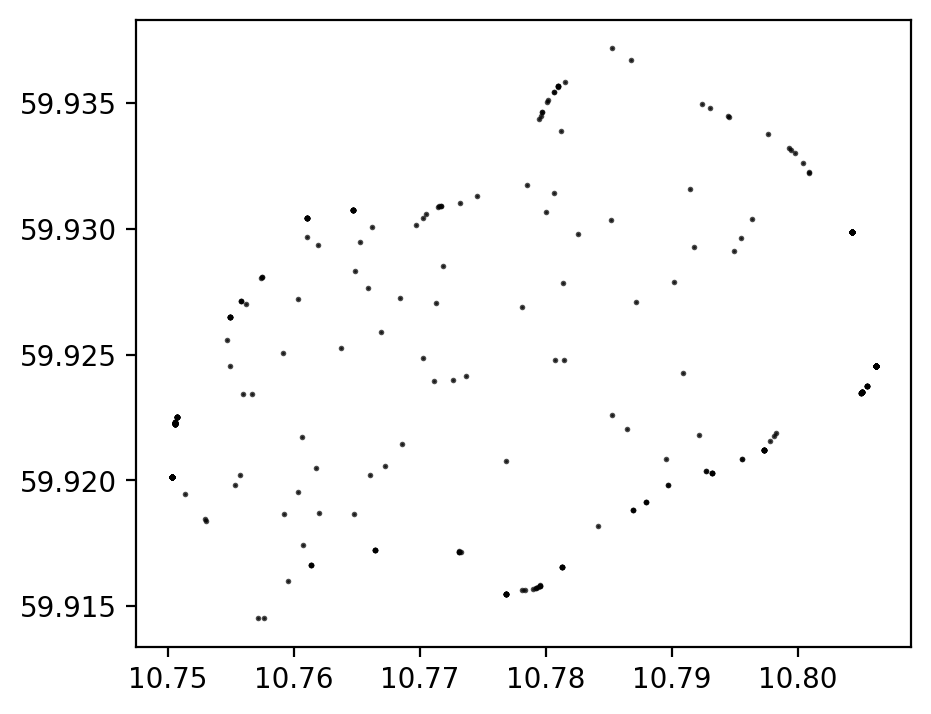

In [213]:
# visualize the snapped points
snapped_points_gdf.plot(markersize=1, color='black', alpha=0.7, figsize=(5, 5))

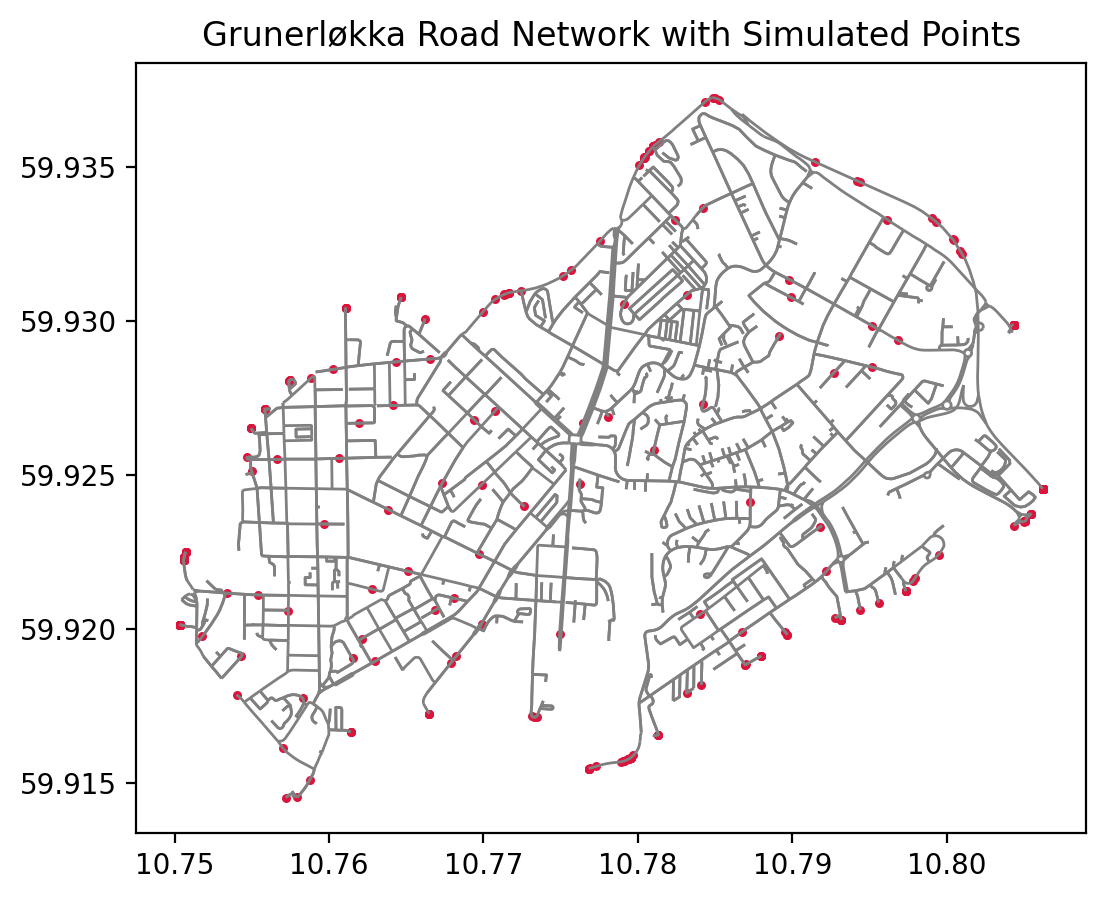

In [229]:
# Plot the road network
fig, ax = plt.subplots(figsize=(10, 5))  # Adjust the figure size as needed
gruner_gdf_edges.plot(ax=ax, linewidth=1, edgecolor='gray')  # Plot edges; adjust style as desired
snapped_points_gdf.plot(ax=ax, color='crimson', markersize=5)  # Plot points; adjust color and size as desired
ax.set_title('Grunerløkka Road Network with Simulated Points'); plt.show()

In [266]:
# Compute weight/distance to crime hotspots
from geopy.distance import great_circle

# Define the crime hotspot location
crime_hotspot_location = (59.9211733, 10.7531202)

# Function to calculate distance to the crime hotspot
def calculate_distance_to_hotspot(point, hotspot):
    return great_circle((point.y, point.x), hotspot).meters

# Choose a scaling factor that adjusts the weights to your desired range
scaling_factor = 1500  # Adjust this value as needed to get the desired weight range

# Calculate weights for each point (inverse of distance for simplicity)
# Note: You might want to normalize or scale these weights based on your specific needs
snapped_points_gdf['weight'] = snapped_points_gdf['geometry'].apply(lambda x: scaling_factor / calculate_distance_to_hotspot(x, crime_hotspot_location))

# Print the first 5 points with weights
print(snapped_points_gdf.head(5))

                    geometry    weight
0  POINT (10.79735 59.92123)  0.608569
1  POINT (10.79735 59.92123)  0.608569
2  POINT (10.80505 59.92349)  0.516324
3  POINT (10.80506 59.92350)  0.516163
4  POINT (10.80433 59.92988)  0.497798


In [267]:
print("Weight statistics:\n", snapped_points_gdf['weight'].describe())

Weight statistics:
 count    471.000000
mean       2.821261
std        5.459993
min        0.497798
25%        0.511555
50%        0.946420
75%        3.234931
max      101.312031
Name: weight, dtype: float64


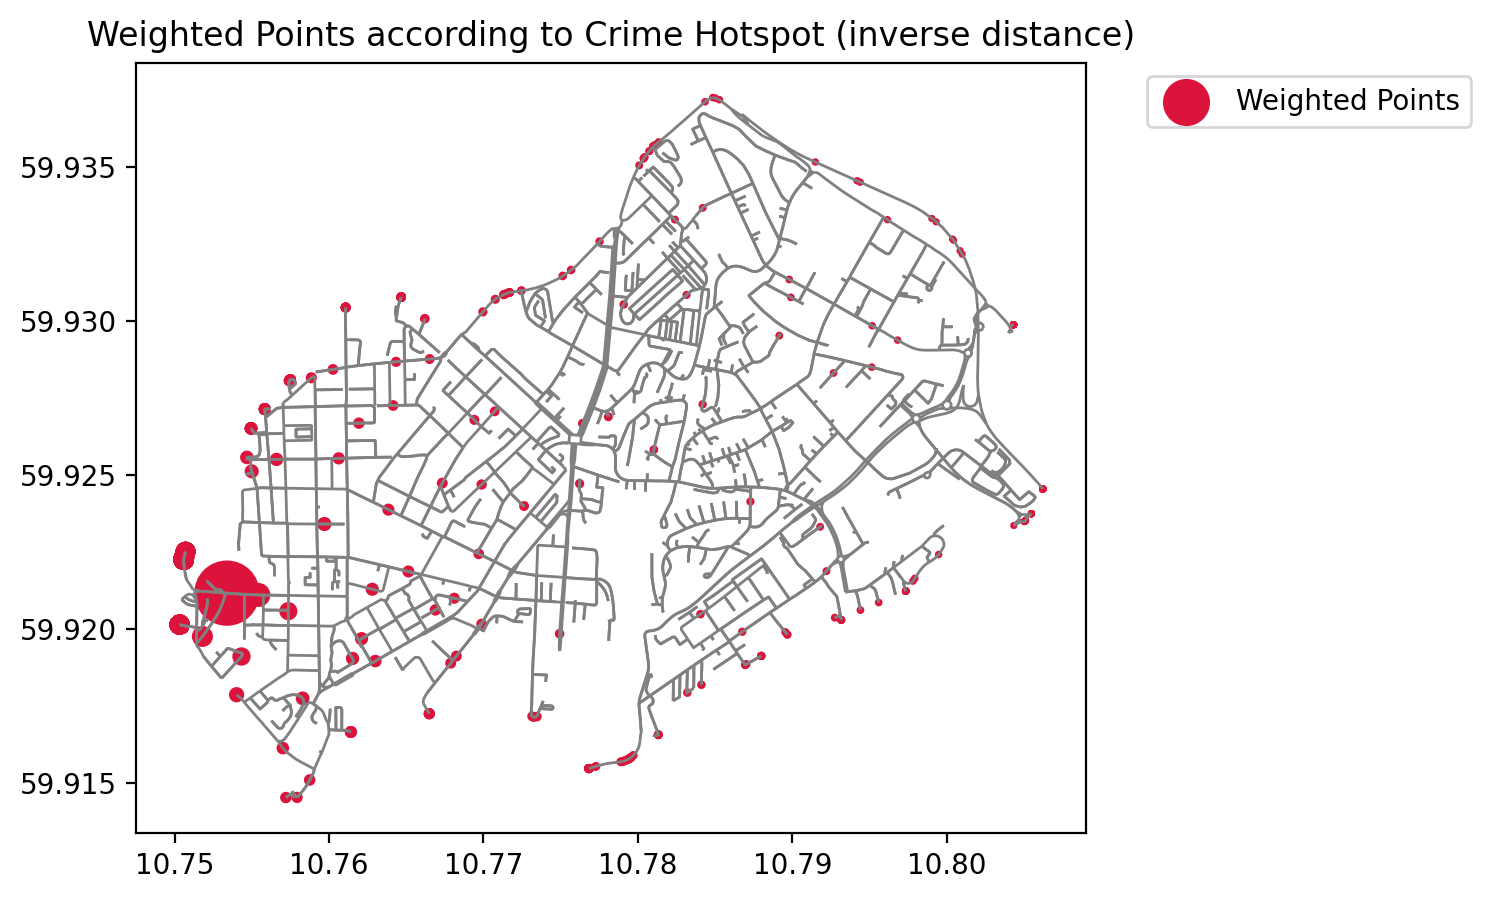

In [273]:
# Plot the road network with weighted points
fig, ax = plt.subplots(figsize=(10, 5))  # Adjust the figure size as needed
gruner_gdf_edges.plot(ax=ax, linewidth=1, edgecolor='gray')  # Plot edges; adjust style as desired
snapped_points_gdf.plot(ax=ax, 
                        color='crimson', 
                        label='Weighted Points',
                        markersize=snapped_points_gdf['weight']  * 5)  # Plot points; adjust color and size as desired
ax.set_title('Weighted Points according to Crime Hotspot (inverse distance)')
plt.legend(loc="upper left", bbox_to_anchor=(1.05, 1)); plt.show()

##### Adding facilities (police car locations)
Current approach: Manually pick 10 logical locations from OpenStreetMap based on demand nodes, crime hotspots, intersections, etc.

In [287]:
import geopandas as gpd
from shapely.geometry import Point

# Define the police car locations
police_car_locations = [
    (59.9223233, 10.7612002),
    (59.9254773, 10.7611394),
    (59.9199786, 10.7666671),
    (59.9260426, 10.7765093),
    (59.9285290, 10.7780040),
    (59.9317113, 10.7885055),
    (59.9261466, 10.7935162),
    (59.9244527, 10.7892110),
    (59.9206872, 10.7835711),
    (59.9247590, 10.7828007)
]

# Convert locations to a GeoDataFrame
police_car_gdf = gpd.GeoDataFrame({
    'geometry': [Point(xy) for xy in police_car_locations]
}, crs="EPSG:4326")

police_car_gdf.head()

# Optionally, you might want to snap these locations to the nearest road as well
# If you want to ensure they are on the network, similar to how you processed the event points


geometry
0  POINT (59.92232 10.76120)
1  POINT (59.92548 10.76114)
2  POINT (59.91998 10.76667)
3  POINT (59.92604 10.77651)
4  POINT (59.92853 10.77800)

In [285]:
# Snap points to the nearest road
car_points_snapped = []
for point in police_car_gdf["geometry"]:
    nearest_geom = nearest_points(point, gruner_gdf_edges.unary_union)[1]
    car_points_snapped.append(nearest_geom)

# Create a GeoDataFrame for the snapped points
car_points_snapped_gdf = gpd.GeoDataFrame(geometry=car_points_snapped, crs=oslo_population.crs)
car_points_snapped_gdf.head()

geometry
0  POINT (10.80549 59.92374)
1  POINT (10.80549 59.92374)
2  POINT (10.80549 59.92374)
3  POINT (10.80549 59.92374)
4  POINT (10.80549 59.92374)

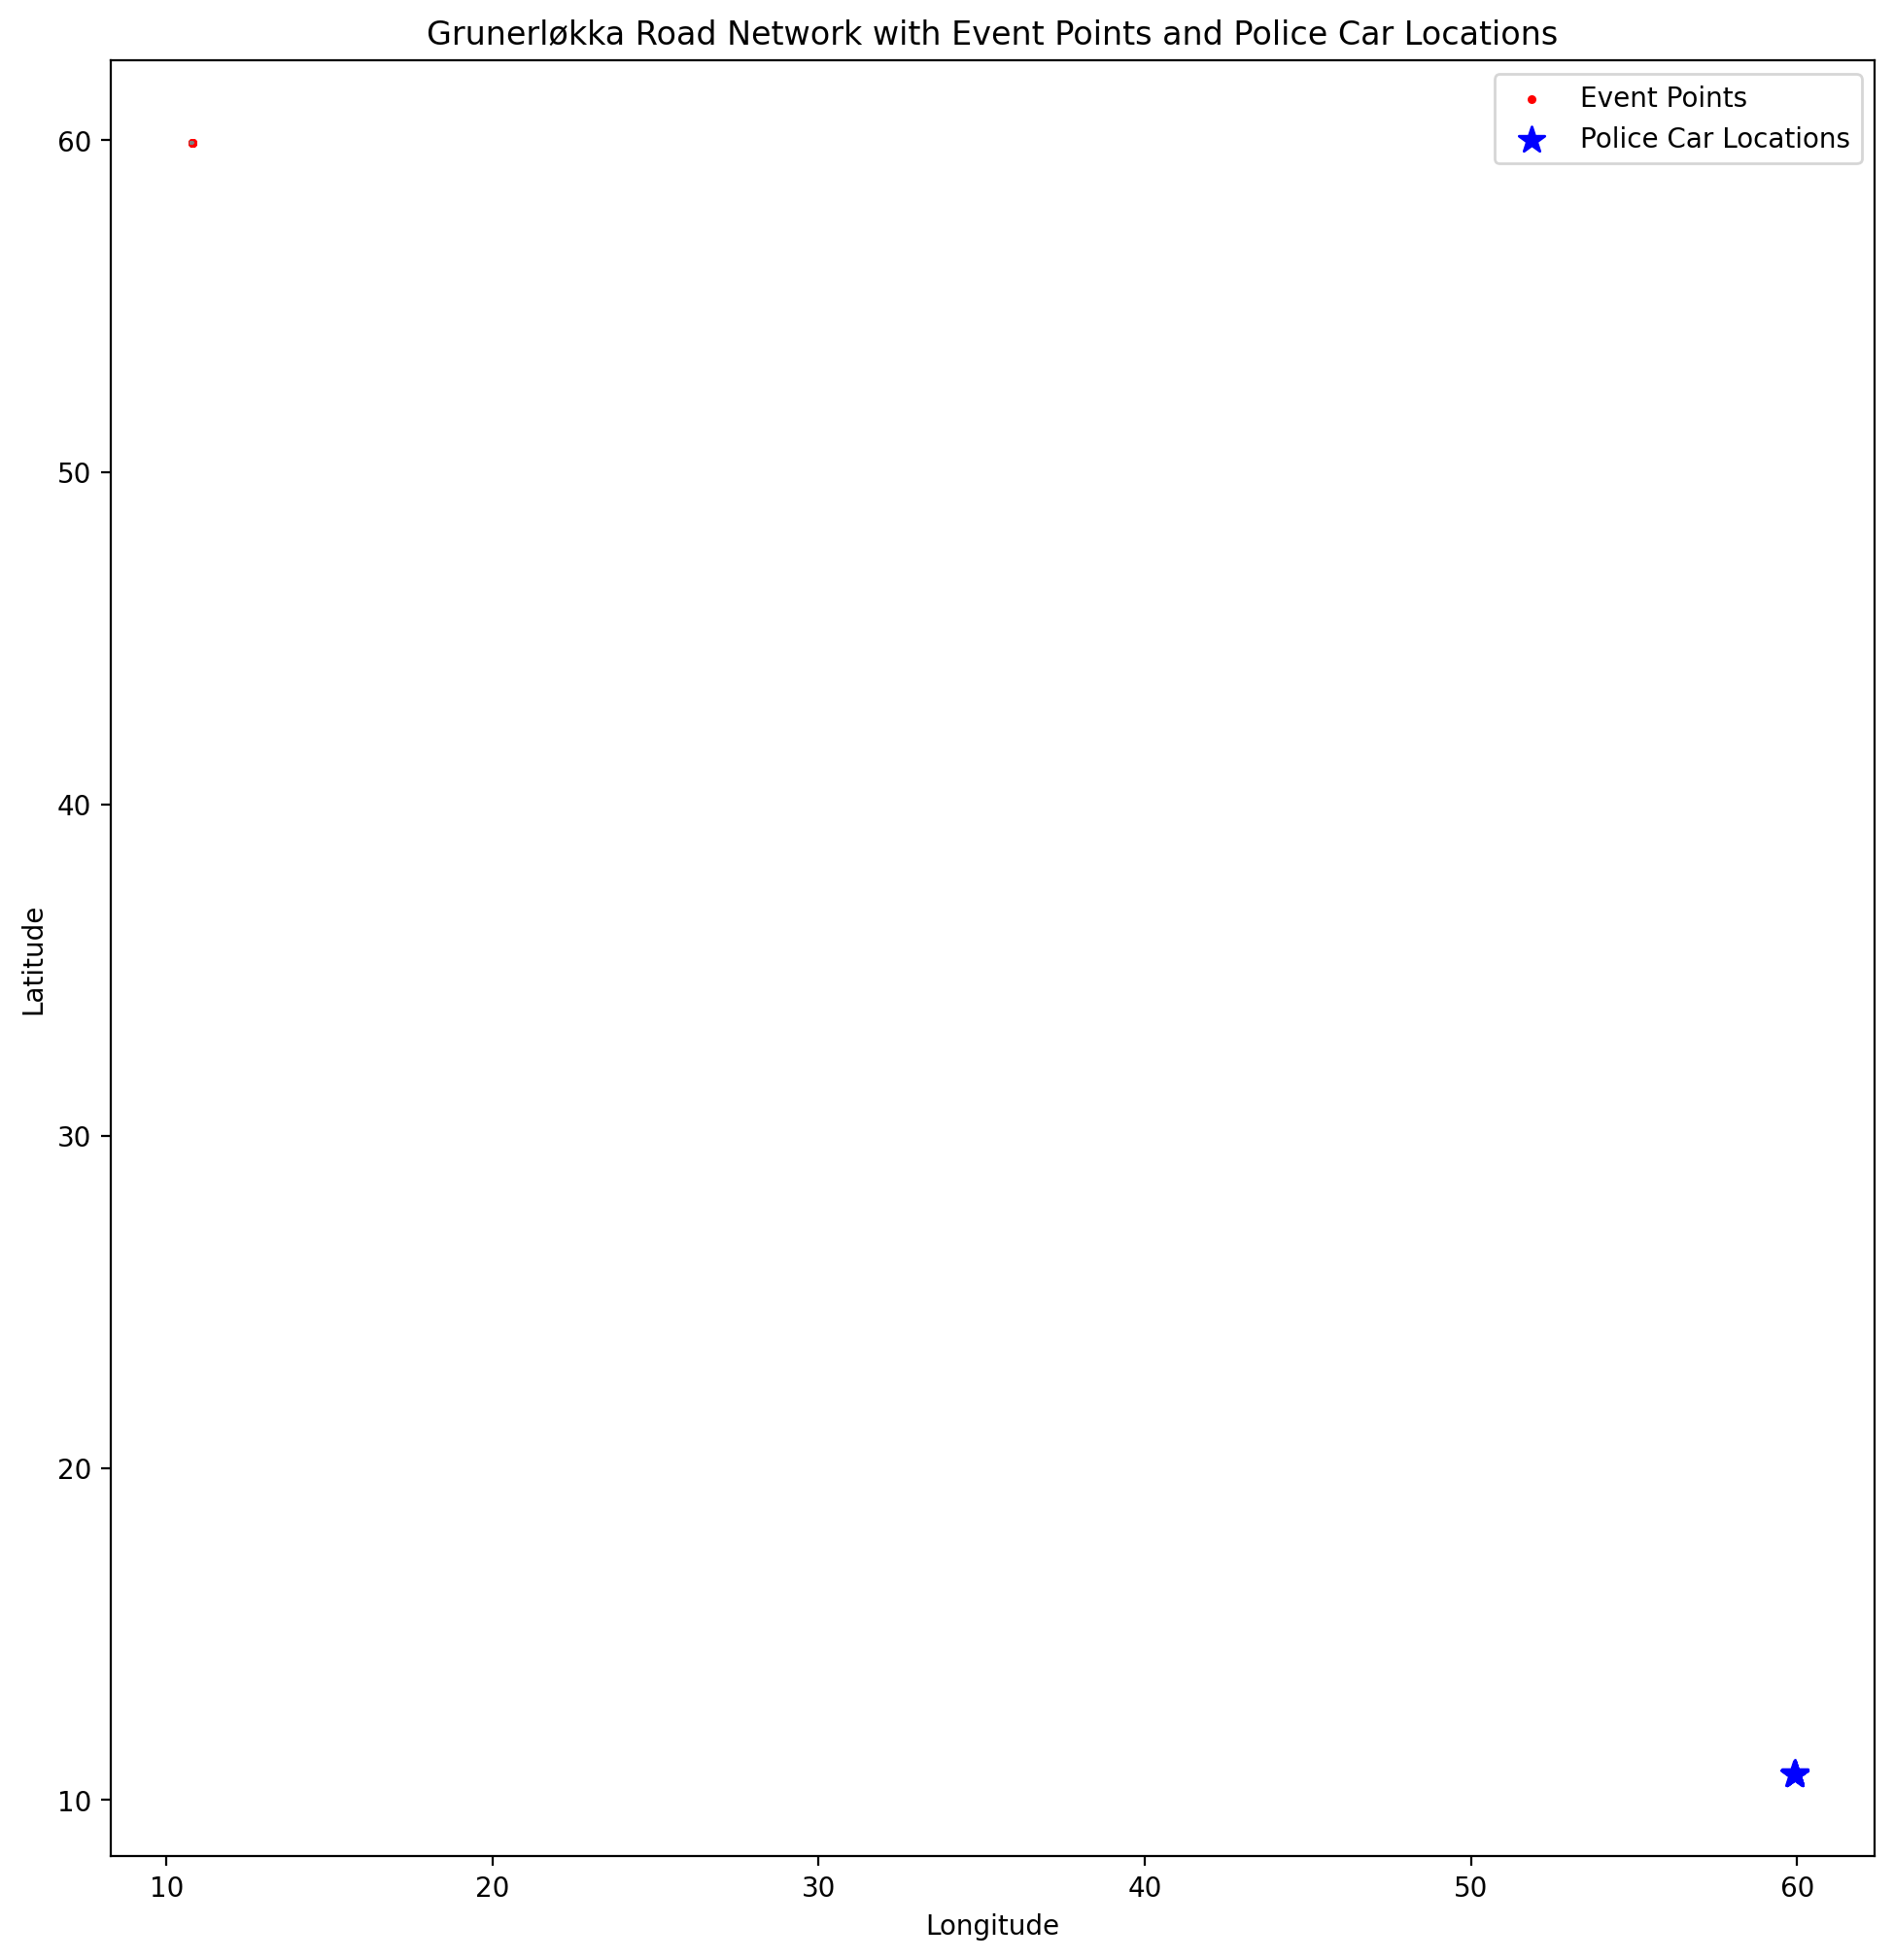

In [286]:
import matplotlib.pyplot as plt

# Plot the road network
fig, ax = plt.subplots(figsize=(12, 12))
gruner_gdf_edges.plot(ax=ax, linewidth=1, edgecolor='gray')

# Overlay the event points
car_points_snapped_gdf.plot(ax=ax, color='red', markersize=5, label='Event Points')

# Overlay the police car locations
police_car_gdf.plot(ax=ax, color='blue', marker='*', markersize=100, label='Police Car Locations')

# Legend
plt.legend()

# Set title and labels
ax.set_title('Grunerløkka Road Network with Event Points and Police Car Locations')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Show the plot
plt.show()


## 2. PySAL spopt and spaghetti

Preparing network for optimization.

Since the model needs a cost matrix (distance, time, etc.) we should define some variables. First we will assign some the number of clients and facility locations, then the maximum service radius, followed by random seeds in order to reproduce the results. Finally, the solver, assigned below as `pulp.COIN_CMD`, is an interface to optimization solver developed by [COIN-OR](https://github.com/coin-or/Cbc). If you want to use another optimization interface, such as Gurobi or CPLEX, see this [guide](https://coin-or.github.io/pulp/guides/how_to_configure_solvers.html) that explains how to achieve this.

In [143]:
# quantity demand points
CLIENT_COUNT = 100

# quantity supply points
FACILITY_COUNT = 10

# maximum service radius (in distance units)
SERVICE_RADIUS = 1000 # in meters

# number of candidate facilities in optimal solution
P_FACILITIES = 4

# random seeds for reproducibility
CLIENT_SEED = 5
FACILITY_SEED = 6

# set the solver
# solver = pulp.COIN_CMD(msg=False, warmStart=True) # I don't have this solver
solver = pulp.GLPK_CMD(msg=False) # does not support warm start?


## Lattice 10x10

Create a 10x10 lattice with 9 interior lines, both vertical and horizontal.

In [144]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    # ignore deprecation warning - GH pysal/libpysal#468
    lattice = spaghetti.regular_lattice((0, 0, 10, 10), 9, exterior=True)
ntw = spaghetti.Network(in_data=lattice)

print(type(lattice))
print(type(ntw))

<class 'list'>
<class 'spaghetti.network.Network'>


Transform the `spaghetti` instance into a geodataframe.

In [145]:
# replaced 'streets' with 'streets_ORIGINAL'
streets_ORIGINAL = spaghetti.element_as_gdf(ntw, arcs=True)
print(type(streets_ORIGINAL))
streets_ORIGINAL.head()

<class 'geopandas.geodataframe.GeoDataFrame'>


id                                       geometry  comp_label
0   (0, 1)  LINESTRING (0.00000 0.00000, 1.00000 0.00000)           0
1   (0, 2)  LINESTRING (0.00000 0.00000, 0.00000 1.00000)           0
2   (1, 3)  LINESTRING (1.00000 0.00000, 1.00000 1.00000)           0
3  (1, 22)  LINESTRING (1.00000 0.00000, 2.00000 0.00000)           0
4   (2, 3)  LINESTRING (0.00000 1.00000, 1.00000 1.00000)           0

In [146]:
streets_buffered = gpd.GeoDataFrame(
    gpd.GeoSeries(streets["geometry"].buffer(50).unary_union),
    crs=streets.crs,
    columns=["geometry"],
)

Plotting the network created by `spaghetti` we can verify that it mimics a district with quarters and streets.

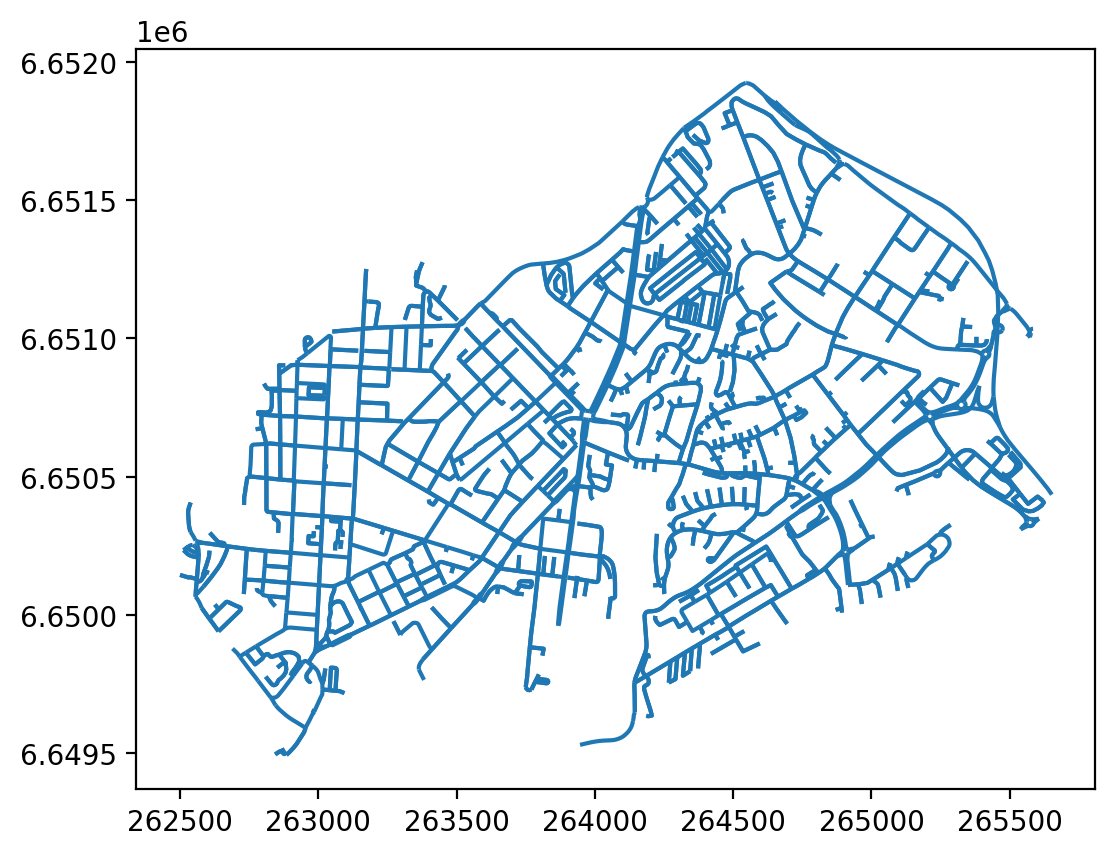

In [147]:
streets.plot();

## Simulate points in a network

The `simulated_geo_points` function simulates points near a network. In this case, it uses the 10x10 lattice network created using the `spaghetti` package. Below we use the function defined above and simulate the points near the lattice edges.

In [148]:
client_points = simulated_geo_points(
    streets_buffered, needed=CLIENT_COUNT, seed=CLIENT_SEED
)
facility_points = simulated_geo_points(
    streets_buffered, needed=FACILITY_COUNT, seed=FACILITY_SEED
)

Plotting the 100 client and 10 facility points we can see that the function generates dummy points to an area of 10x10, which is the area created by our lattice created on previous cells.

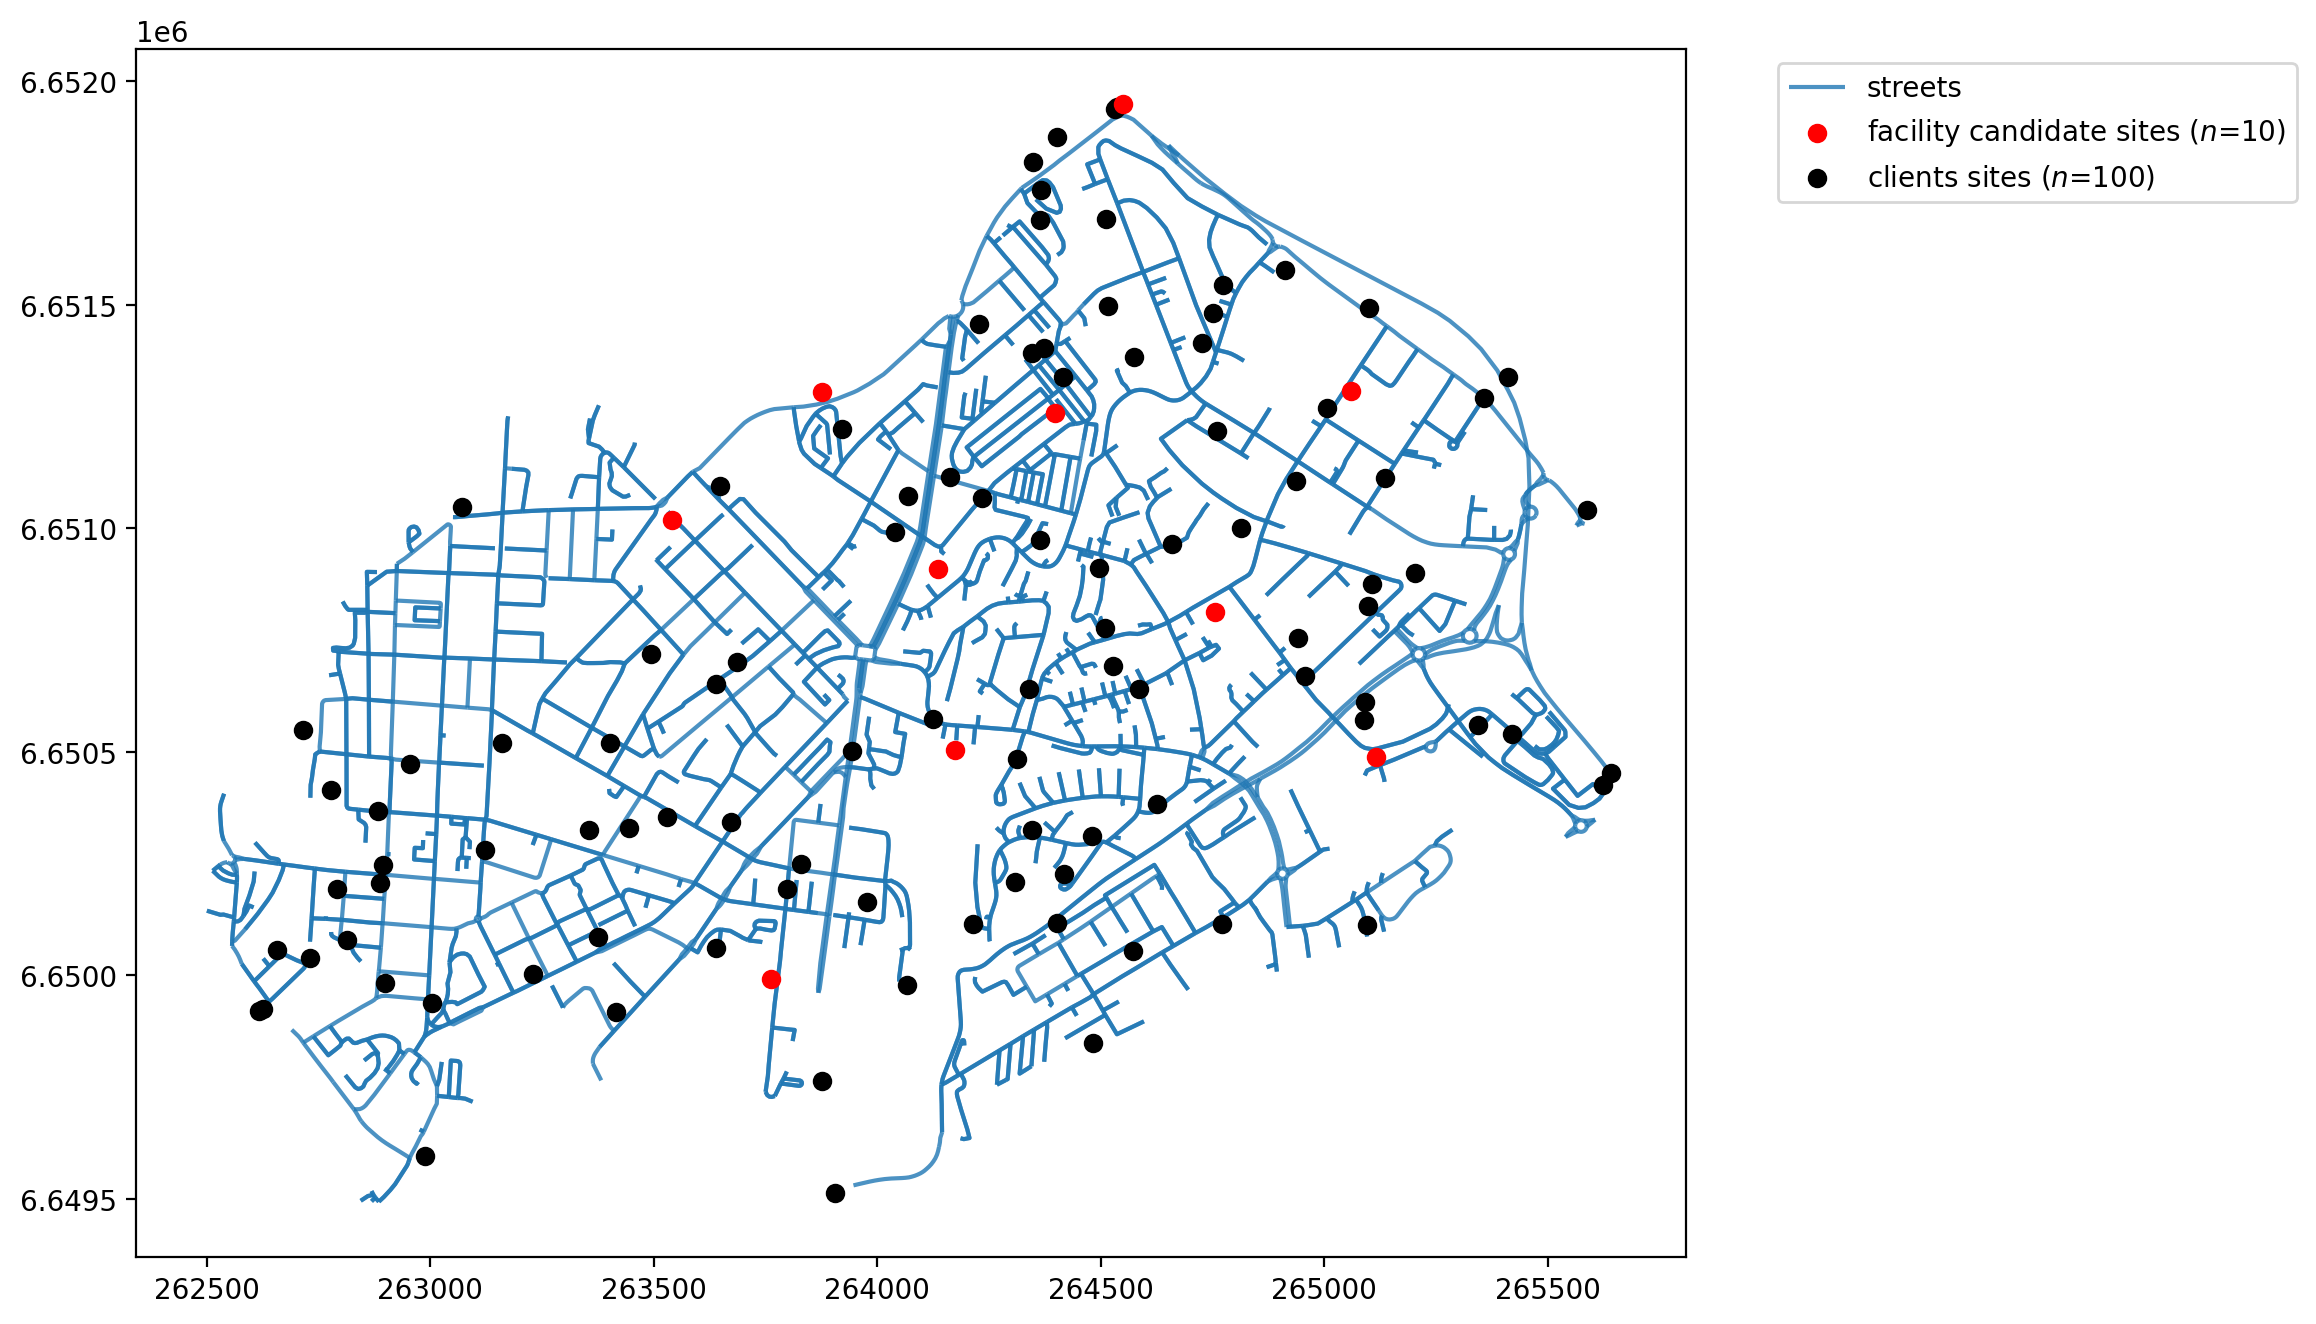

In [149]:
fig, ax = plt.subplots(figsize=(10, 10))
streets.plot(ax=ax, alpha=0.8, zorder=1, label="streets")
facility_points.plot(
    ax=ax, color="red", zorder=2, label=f"facility candidate sites ($n$={FACILITY_COUNT})"
)
client_points.plot(ax=ax, color="black", label=f"clients sites ($n$={CLIENT_COUNT})")
plt.legend(loc="upper left", bbox_to_anchor=(1.05, 1));

For each client point the model supposes that there is a weight. So, we assign some random integers using `numpy` to simulate these weights. We will simulate weights in a range from a minimum of 1 and a maximum of 12.

In [150]:
np.random.seed(0)
ai = np.random.randint(1, 12, CLIENT_COUNT)
ai

array([ 6,  1,  4,  4,  8, 10,  4,  6,  3,  5,  8,  7,  9,  9, 11,  2,  7,
        8,  8,  9,  2,  6, 10,  9, 10,  5,  4,  1,  4,  6,  1,  3,  4,  9,
        2,  4,  4,  4,  8,  1,  2, 10, 10,  1, 11,  5,  8,  4,  3,  8,  3,
        1,  1,  5,  6,  6,  7,  9,  5,  2,  5, 10, 11, 11,  9,  2,  2,  8,
       10, 10,  4,  7,  8,  3,  1,  4,  6, 10, 11,  5,  5,  7,  5,  5,  4,
        5,  5,  9,  5,  4, 11,  8,  6,  6,  1,  2,  6, 10,  4,  1])

What's total the value of "weighted" clients?

In [249]:
client_points["weights"] = ai
client_points["weights"].sum()

client_points.head()

geometry  weights
0  POINT (264038.587 6650991.160)        6
1  POINT (264941.072 6650755.063)        1
2  POINT (263415.424 6649918.464)        4
3  POINT (263797.348 6650192.590)        4
4  POINT (264495.125 6650910.444)        8

In [250]:
snapped_points_gdf.head()

geometry    weight
0  POINT (10.79735 59.92123)  0.608569
1  POINT (10.79735 59.92123)  0.608569
2  POINT (10.80505 59.92349)  0.516324
3  POINT (10.80506 59.92350)  0.516163
4  POINT (10.80433 59.92988)  0.497798

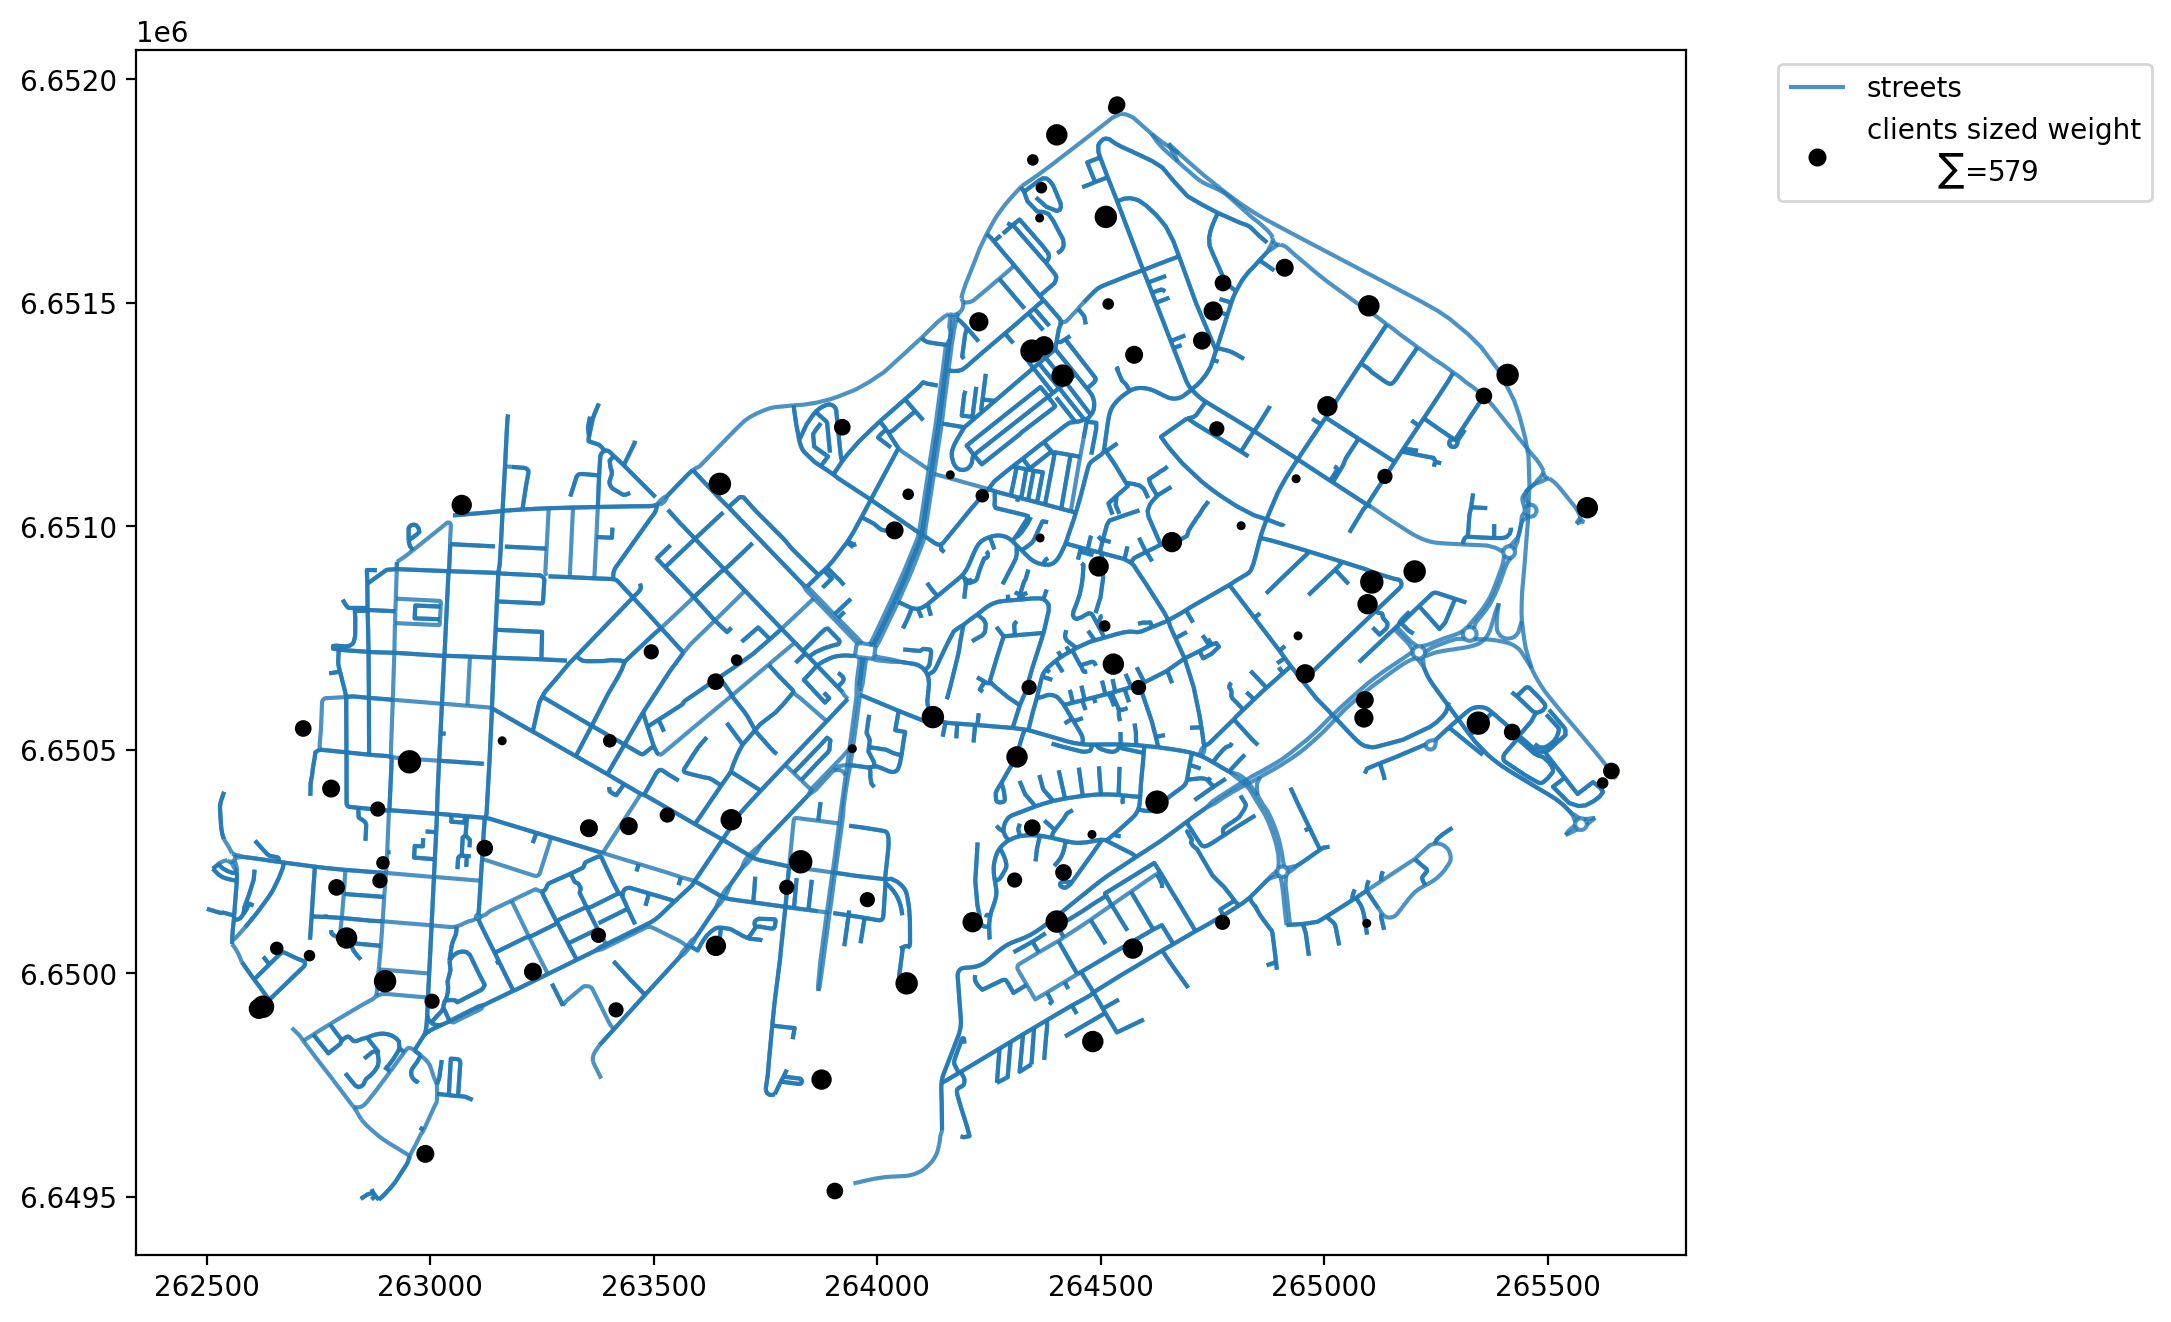

In [246]:
fig, ax = plt.subplots(figsize=(10, 10))
streets.plot(ax=ax, alpha=0.8, zorder=1, label="streets")
client_points.plot(
    ax=ax,
    color="black",
    label=f"clients sized weight\n\t$\sum$={client_points['weights'].sum()}",
    markersize=ai*5
)
plt.legend(loc="upper left", bbox_to_anchor=(1.05, 1));

## Assign simulated points network locations

The simulated client and facility points do not adhere to network space. Calculating distances between them without restricting movement to the network results in a euclidean distances,'as the crow flies.' While this is acceptable for some applications, for others it is more realistic to consider network traversal (e.g. Does a mail carrier follow roads to deliver letters or fly from mailbox to mailbox?).

In our first example we will consider distance along the 10x10 lattice network created above. Therefore, we must first snap the observation points to the network prior to calculating a cost matrix.

In [153]:
# transforming my network into a spaghetti network, equivalent to the spaghetti-generated lattice
ntw = spaghetti.Network(in_data=gruner_gdf_edges_projected)
print(type(ntw))

<class 'spaghetti.network.Network'>


In [154]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    # ignore deprecation warning - GH pysal/libpysal#468
    ntw.snapobservations(client_points, "clients", attribute=True)
clients_snapped = spaghetti.element_as_gdf(ntw, pp_name="clients", snapped=True)
clients_snapped.drop(columns=["id", "comp_label"], inplace=True)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    # ignore deprecation warning - GH pysal/libpysal#468
    ntw.snapobservations(facility_points, "facilities", attribute=True)
facilities_snapped = spaghetti.element_as_gdf(ntw, pp_name="facilities", snapped=True)
facilities_snapped.drop(columns=["id", "comp_label"], inplace=True)

Now the plot seems more organized as the points occupy network space. The network is plotted below with the network locations of the facility points and clients points.

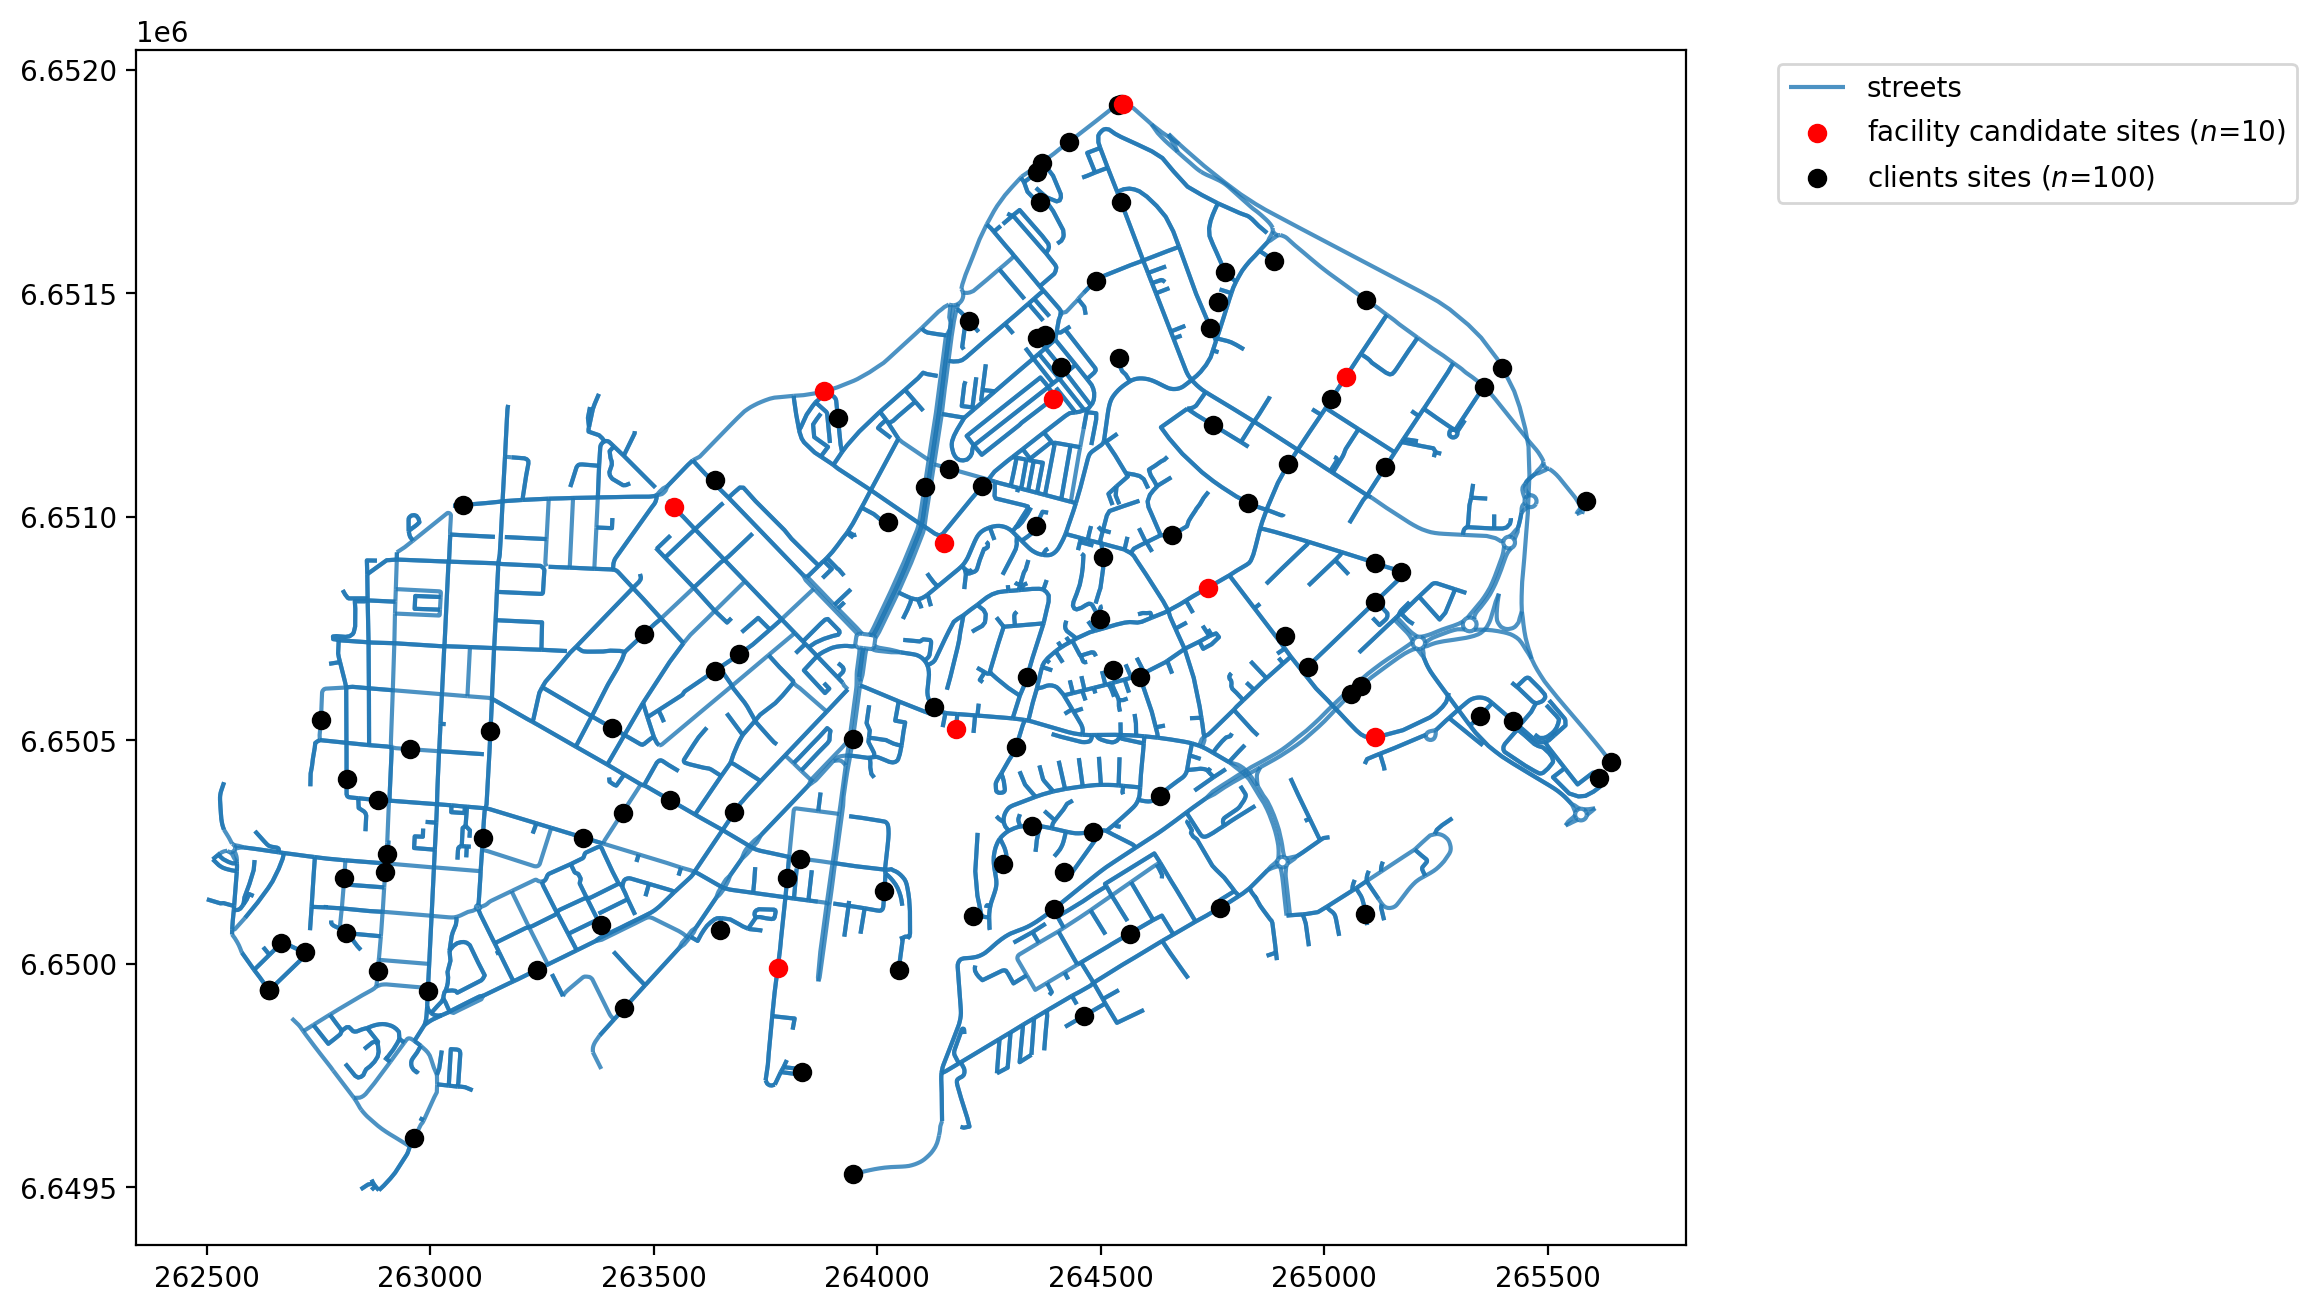

In [155]:
fig, ax = plt.subplots(figsize=(10, 10))
streets.plot(ax=ax, alpha=0.8, zorder=1, label="streets")
facilities_snapped.plot(
    ax=ax, color="red", zorder=2, label=f"facility candidate sites ($n$={FACILITY_COUNT})"
)
clients_snapped.plot(ax=ax, color="black", label=f"clients sites ($n$={CLIENT_COUNT})")
plt.legend(loc="upper left", bbox_to_anchor=(1.05, 1));

In [274]:
# print ntw
print(type(ntw))
print(ntw.pointpatterns)

<class 'spaghetti.network.Network'>
{'clients': <spaghetti.network.PointPattern object at 0x000001EBC4FA7190>, 'facilities': <spaghetti.network.PointPattern object at 0x000001EBC4FBC750>}


## Calculating the (network distance) cost matrix
SERVICE_RADIUS = 1500  => 1:40 compute time

In [156]:
%%time
cost_matrix = ntw.allneighbordistances(
    sourcepattern=ntw.pointpatterns["clients"],
    destpattern=ntw.pointpatterns["facilities"],
)
cost_matrix.shape

CPU times: total: 1min 45s
Wall time: 2min 6s


(100, 10)

The expected result here is a network distance between clients and facilities points, in our case a 2D 100x10 array.

In [157]:
cost_matrix[:5,:]

array([[ 813.14915279,  763.6870447 ,  472.46428746,  321.18984752,
        1294.01884653, 1699.42681363, 1608.04396177, 1148.13498875,
        1321.33258278,  884.7316332 ],
       [ 928.26407286, 1777.43974256, 1652.88727431, 1125.57496112,
        1649.00737997,  326.90999151,  726.66087618,  256.73695253,
        2031.06669704, 1122.52082369],
       [1345.96007722, 1510.7748665 , 1821.27405911, 1387.18055069,
        2433.6073719 , 2347.26623376, 2598.71564736, 2017.89044251,
         647.9222698 , 1950.72233637],
       [ 970.4624759 , 1181.45171593, 1452.05984596, 1011.68294938,
        2058.10977058, 1971.76863244, 2223.21804605, 1642.39284119,
         203.17060624, 1575.22473506],
       [ 890.9412072 , 1346.18257891, 1099.20057516,  571.88826197,
        1330.98342696,  909.06770436,  938.60108433,  357.77587947,
        1599.80953339,  568.83412455]])

In [158]:
cost_matrix[-5:,:]

array([[1794.2459604 , 2643.42163011, 2674.29608153, 2146.98376835,
        2411.14261687,  952.80559012, 1652.5047413 , 1278.14575976,
        2897.04858459, 2143.92963092],
       [1780.15607219, 2127.51646622, 1513.95739004, 1220.66110866,
         541.51033549, 1482.53038159,  564.84640737, 1042.13983791,
        2388.87720794, 1045.85586484],
       [ 848.56998877,  780.27369889,  413.66634916,  753.09543579,
        1386.11341045, 1849.87614531, 2039.94955004, 1520.50035406,
        1337.91923697, 1316.63722147],
       [ 997.68302055,  406.77275255,  862.66071259, 1031.16970679,
        1835.10777387, 1998.98917709, 2250.4385907 , 1669.61338584,
        1086.98231529, 1594.71149247],
       [ 723.68363404, 1572.85930375, 1770.1601423 , 1329.78324572,
        2184.65211577,  765.96731132, 1342.3950536 ,  761.56984874,
        1826.48625823, 1422.50281336]])

With ``MCLP.from_cost_matrix`` we model the MCLP to cover as much demand as possible with $p$ facility points within `SERVICE_RADIUS` distance units using the network distance cost matrix calculated above.

In [159]:
mclp_from_cm = MCLP.from_cost_matrix(
    cost_matrix,
    ai,
    SERVICE_RADIUS,
    p_facilities=P_FACILITIES,
    name="MCLP-network-distance"
)

The expected result is a solved instance of `MCLP`.

In [160]:
mclp_from_cm = mclp_from_cm.solve(solver)
mclp_from_cm

How much coverage is observed?

In [161]:
print(f"{mclp_from_cm.perc_cov}% coverage is observed")

77.0% coverage is observed


Define the decision variable names used for mapping later.

In [162]:
facility_points["dv"] = mclp_from_cm.fac_vars
facility_points["dv"] = facility_points["dv"].map(
    lambda x: x.name.replace("_", "").replace("x", "y")
)
facilities_snapped["dv"] = facility_points["dv"]
facility_points

geometry  dv
0  POINT (264173.250 6650503.068)  y0
1  POINT (263540.984 6651018.420)  y1
2  POINT (263875.098 6651305.206)  y2
3  POINT (264134.935 6650907.967)  y3
4  POINT (264549.006 6651948.644)  y4
5  POINT (265116.531 6650488.884)  y5
6  POINT (265059.007 6651306.533)  y6
7  POINT (264756.423 6650812.032)  y7
8  POINT (263761.643 6649992.410)  y8
9  POINT (264398.267 6651258.278)  y9

## Calculating euclidean distance from a `GeoDataFrame`

With ``MCLP.from_geodataframe`` we model the MCLP to cover as much demand as possible with $p$ facility points within `SERVICE_RADIUS` distance units using geodataframes to calculate a euclidean distance cost matrix.

Next we will solve the MCLP considering all 10 candidate locations for potential selection.

In [163]:
distance_metric = "euclidean"
clients_snapped["weights"] = client_points["weights"]
mclp_from_gdf = MCLP.from_geodataframe(
    clients_snapped,
    facilities_snapped,
    "geometry",
    "geometry",
    "weights",
    SERVICE_RADIUS,
    p_facilities=P_FACILITIES,
    distance_metric=distance_metric,
    name=f"MCLP-{distance_metric}-distance"
)

In [164]:
mclp_from_gdf = mclp_from_gdf.solve(solver)
print(f"{mclp_from_gdf.perc_cov}% coverage is observed")

96.0% coverage is observed


However, in many real world applications there may already be existing facility locations with the goal being to add one or more new facilities. Here we will define facilites $y_0$, $y_1$, and $y_3$ as already existing (they must be present in the model solution). This will lead to a sub-optimal solution.

***Important:*** The facilities in `"predefined_loc"` are a binary array where `1` means the associated location must appear in the solution.

In [165]:
facility_points["predefined_loc"] = 0
facility_points.loc[(0, 1, 3), "predefined_loc"] = 1
facilities_snapped["predefined_loc"] = facility_points["predefined_loc"]
facility_points

geometry  dv  predefined_loc
0  POINT (264173.250 6650503.068)  y0               1
1  POINT (263540.984 6651018.420)  y1               1
2  POINT (263875.098 6651305.206)  y2               0
3  POINT (264134.935 6650907.967)  y3               1
4  POINT (264549.006 6651948.644)  y4               0
5  POINT (265116.531 6650488.884)  y5               0
6  POINT (265059.007 6651306.533)  y6               0
7  POINT (264756.423 6650812.032)  y7               0
8  POINT (263761.643 6649992.410)  y8               0
9  POINT (264398.267 6651258.278)  y9               0

In [166]:
mclp_from_gdf_pre = MCLP.from_geodataframe(
    clients_snapped,
    facilities_snapped,
    "geometry",
    "geometry",
    "weights",
    SERVICE_RADIUS,
    p_facilities=P_FACILITIES,
    predefined_facility_col="predefined_loc",
    distance_metric=distance_metric,
    name=f"MCLP-{distance_metric}-distance-predefined"
)

In [167]:
mclp_from_gdf_pre = mclp_from_gdf_pre.solve(solver)
print(f"{mclp_from_gdf_pre.perc_cov}% coverage is observed")

84.0% coverage is observed


## Plotting the results

The two cells below describe the plotting of the results. For each method from the `MCLP` class (`.from_cost_matrix()`, `.from_geodataframe()`) there is a plot displaying the facility site that was selected with a star colored and the points covered with the same color. Demand points covered by more than one facility are displayed in overlapping concentric circles.

In [168]:
dv_colors_arr = [
    "darkcyan",
    "mediumseagreen",
    "saddlebrown",
    "darkslategray",
    "lightskyblue",
    "thistle",
    "lavender",
    "darkgoldenrod",
    "peachpuff",
    "coral",
    "mediumvioletred",
    "blueviolet",
    "fuchsia",
    "cyan",
    "limegreen",
    "mediumorchid",
]
dv_colors = {f"y{i}": dv_colors_arr[i] for i in range(len(dv_colors_arr))}
dv_colors

{'y0': 'darkcyan',
 'y1': 'mediumseagreen',
 'y2': 'saddlebrown',
 'y3': 'darkslategray',
 'y4': 'lightskyblue',
 'y5': 'thistle',
 'y6': 'lavender',
 'y7': 'darkgoldenrod',
 'y8': 'peachpuff',
 'y9': 'coral',
 'y10': 'mediumvioletred',
 'y11': 'blueviolet',
 'y12': 'fuchsia',
 'y13': 'cyan',
 'y14': 'limegreen',
 'y15': 'mediumorchid'}

In [169]:
def plot_results(model, p, facs, clis=None, ax=None):
    """Visualize optimal solution sets and context."""
    if not ax:
        multi_plot = False
        fig, ax = plt.subplots(figsize=(6, 6))
        markersize, markersize_factor = 4, 4
    else:
        ax.axis("off")
        multi_plot = True
        markersize, markersize_factor = 2, 2
    ax.set_title(model.name, fontsize=15)

    # extract facility-client relationships for plotting (except for p-dispersion)
    plot_clis = isinstance(clis, gpd.GeoDataFrame)
    if plot_clis:
        cli_points = {}
    fac_sites = {}
    for i, dv in enumerate(model.fac_vars):
        if dv.varValue:
            dv, predef = facs.loc[i, ["dv", "predefined_loc"]]
            fac_sites[dv] = [i, predef]
            if plot_clis:
                geom = clis.iloc[model.fac2cli[i]]["geometry"]
                cli_points[dv] = geom
    
    # study area and legend entries initialization
    streets.plot(ax=ax, alpha=1, color="black", zorder=1)
    legend_elements = [mlines.Line2D([], [], color="black", label="streets")]
    
    if plot_clis:
        # any clients that not asscociated with a facility
        if model.name.startswith("MCLP"):
            c = "r"
            if model.n_cli_uncov:
                idx = [i for i, v in enumerate(model.cli2fac) if len(v) == 0]
                pnt_kws = dict(ax=ax, fc=c, ec=c, marker="s", markersize=7, zorder=2)
                clis.iloc[idx].plot(**pnt_kws)
            _label = f"Demand sites not covered ($n$={model.n_cli_uncov})"
            _mkws = dict(marker="s", markerfacecolor=c, markeredgecolor=c, linewidth=0)
            legend_elements.append(mlines.Line2D([], [], ms=3, label=_label, **_mkws))

    # all candidate facilities
    facs.plot(ax=ax, fc="orange", marker="*", markersize=200, zorder=8)
    _label = f"Facility sites ($n$={len(model.fac_vars)})"
    _mkws = dict(marker="*", markerfacecolor="orange", markeredgecolor="orange")
    legend_elements.append(mlines.Line2D([], [], ms=7, lw=0, label=_label, **_mkws))
    
    # facility-(client) symbology and legend entries
    zorder = 4
    for fname, (fac, predef) in fac_sites.items():
        cset = dv_colors[fname]
        if plot_clis:
            # clients
            geoms = cli_points[fname]
            gdf = gpd.GeoDataFrame(geoms)
            gdf.plot(ax=ax, zorder=zorder, ec="k", fc=cset, markersize=100 * markersize)
            _label = f"Demand sites covered by {fname}"
            _mkws = dict(markerfacecolor=cset, markeredgecolor="k", ms=markersize + 7)
            legend_elements.append(
                mlines.Line2D([], [], marker="o", lw=0, label=_label, **_mkws)
            )
        # facilities
        ec = "k"
        lw = 2
        predef_label = "predefined"
        if model.name.endswith(predef_label) and predef:
            ec = "r"
            lw = 3
            fname += f" ({predef_label})"
        facs.iloc[[fac]].plot(
            ax=ax, marker="*", markersize=1000, zorder=9, fc=cset, ec=ec, lw=lw
        )
        _mkws = dict(markerfacecolor=cset, markeredgecolor=ec, markeredgewidth=lw)
        legend_elements.append(
            mlines.Line2D([], [], marker="*", ms=20, lw=0, label=fname, **_mkws)
        )
        # increment zorder up and markersize down for stacked client symbology
        zorder += 1
        if plot_clis:
            markersize -= markersize_factor / p
    
    if not multi_plot:
        # legend
        kws = dict(loc="upper left", bbox_to_anchor=(1.05, 0.7))
        plt.legend(handles=legend_elements, **kws)

### MCLP built from cost matrix (network distance)

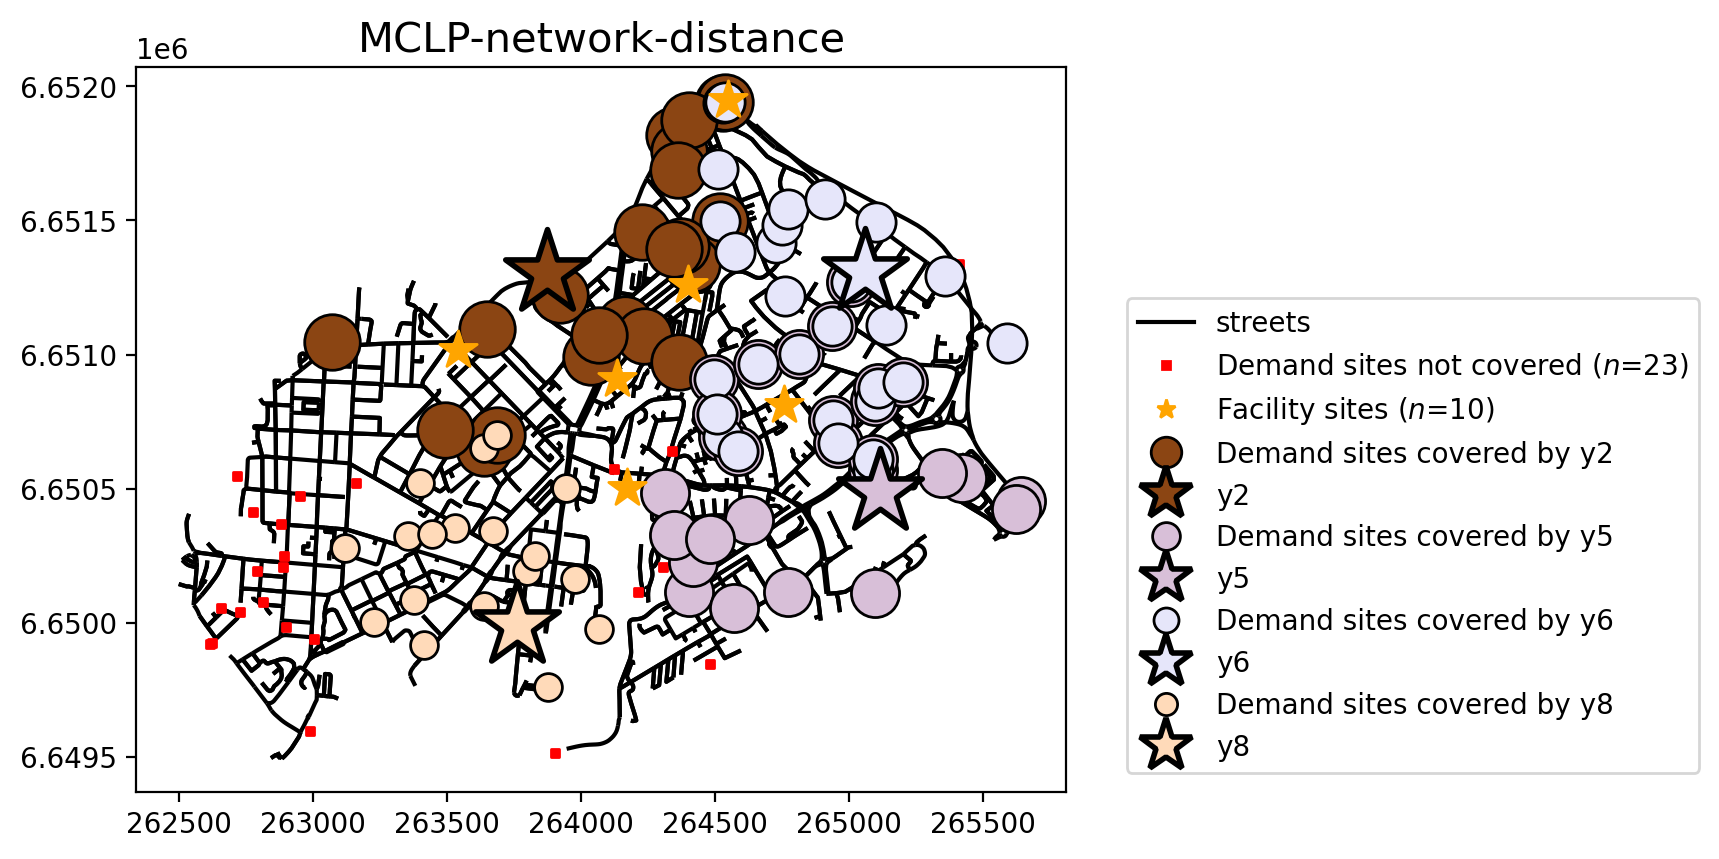

In [170]:
plot_results(mclp_from_cm, P_FACILITIES, facility_points, clis=client_points)

### MCLP built from geodataframes (euclidean distance)

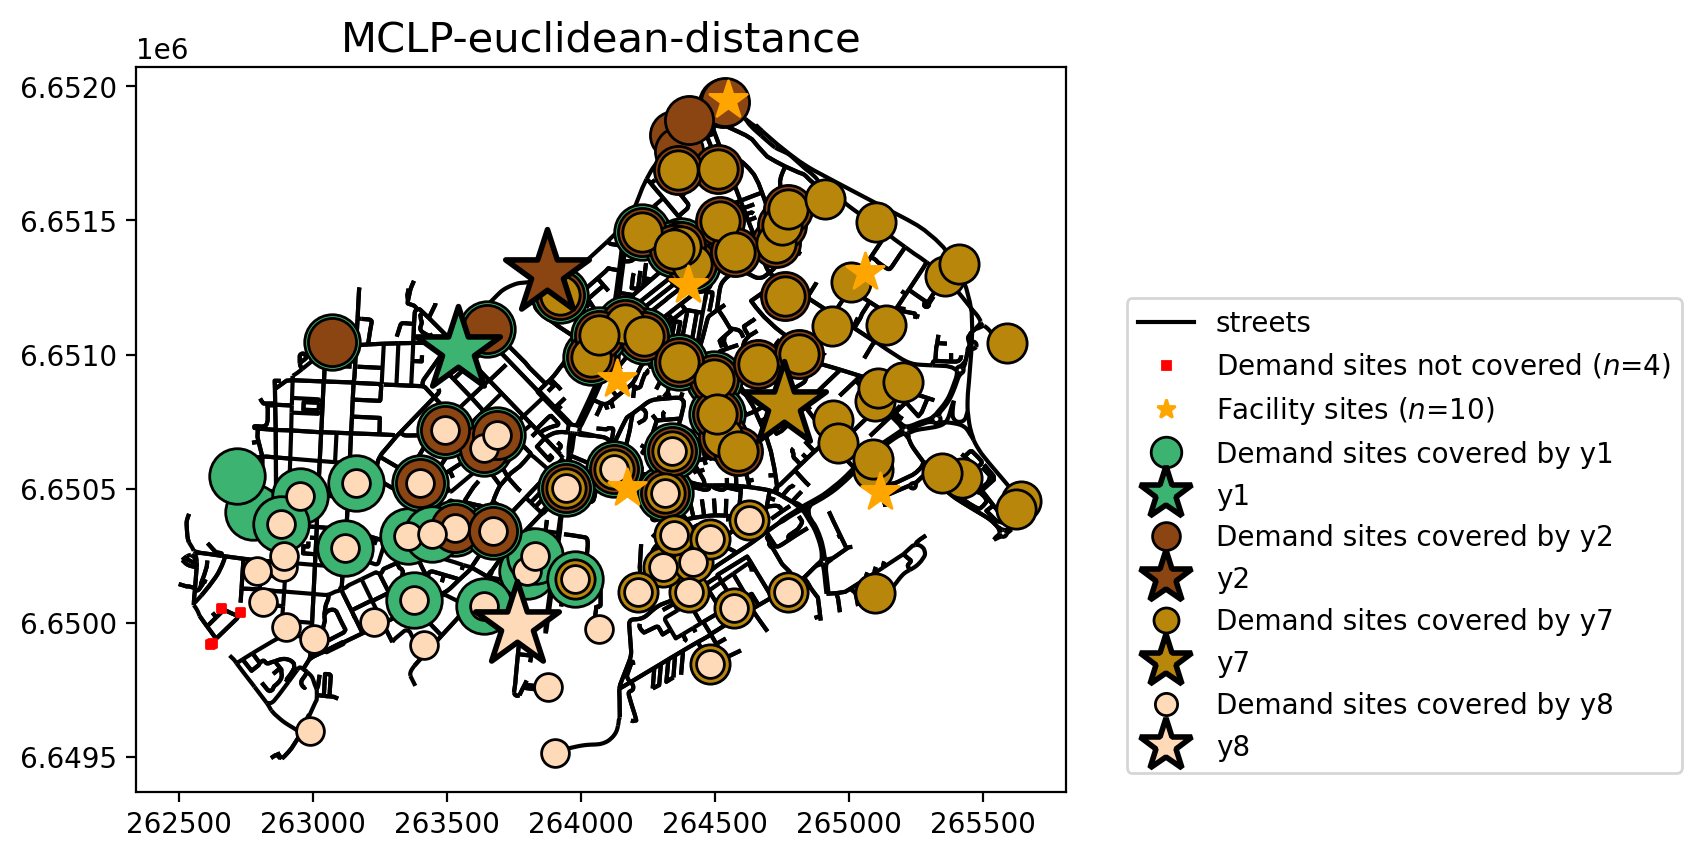

In [171]:
plot_results(mclp_from_gdf, P_FACILITIES, facility_points, clis=client_points)

You may notice that the model results are similar, yet different. This is expected as the distances between facility and demand points are calculated with different metrics (network vs. euclidean distance).

### MCLP with preselected facilities (euclidean distance)

Finally, let's visualize the results of the MCLP when stipulating that facilities $y_0$, $y_1$, and $y_3$ must be included in the final selection.

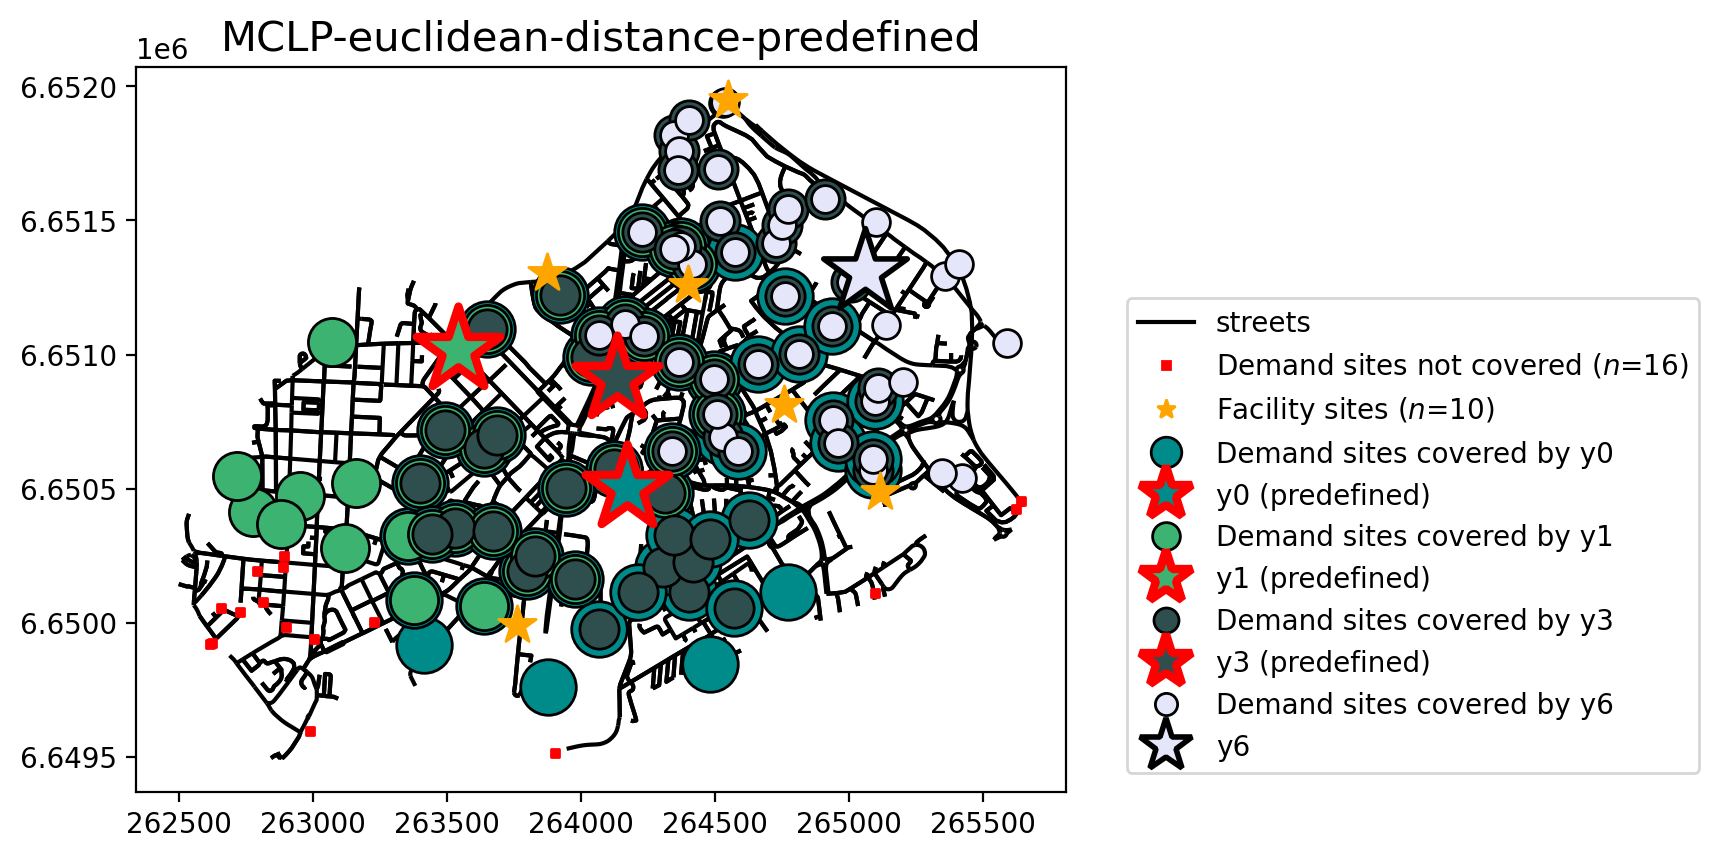

In [172]:
plot_results(mclp_from_gdf_pre, P_FACILITIES, facility_points, clis=client_points)

Here, the differences is explained by the preselected facilities $y_0$, $y_1$ and $y_3$. So, the MCLP model chooses the facility $y_4$ to maximize the coverage given the client points.

-----------------------------------

## Comparing solution from varied metrics

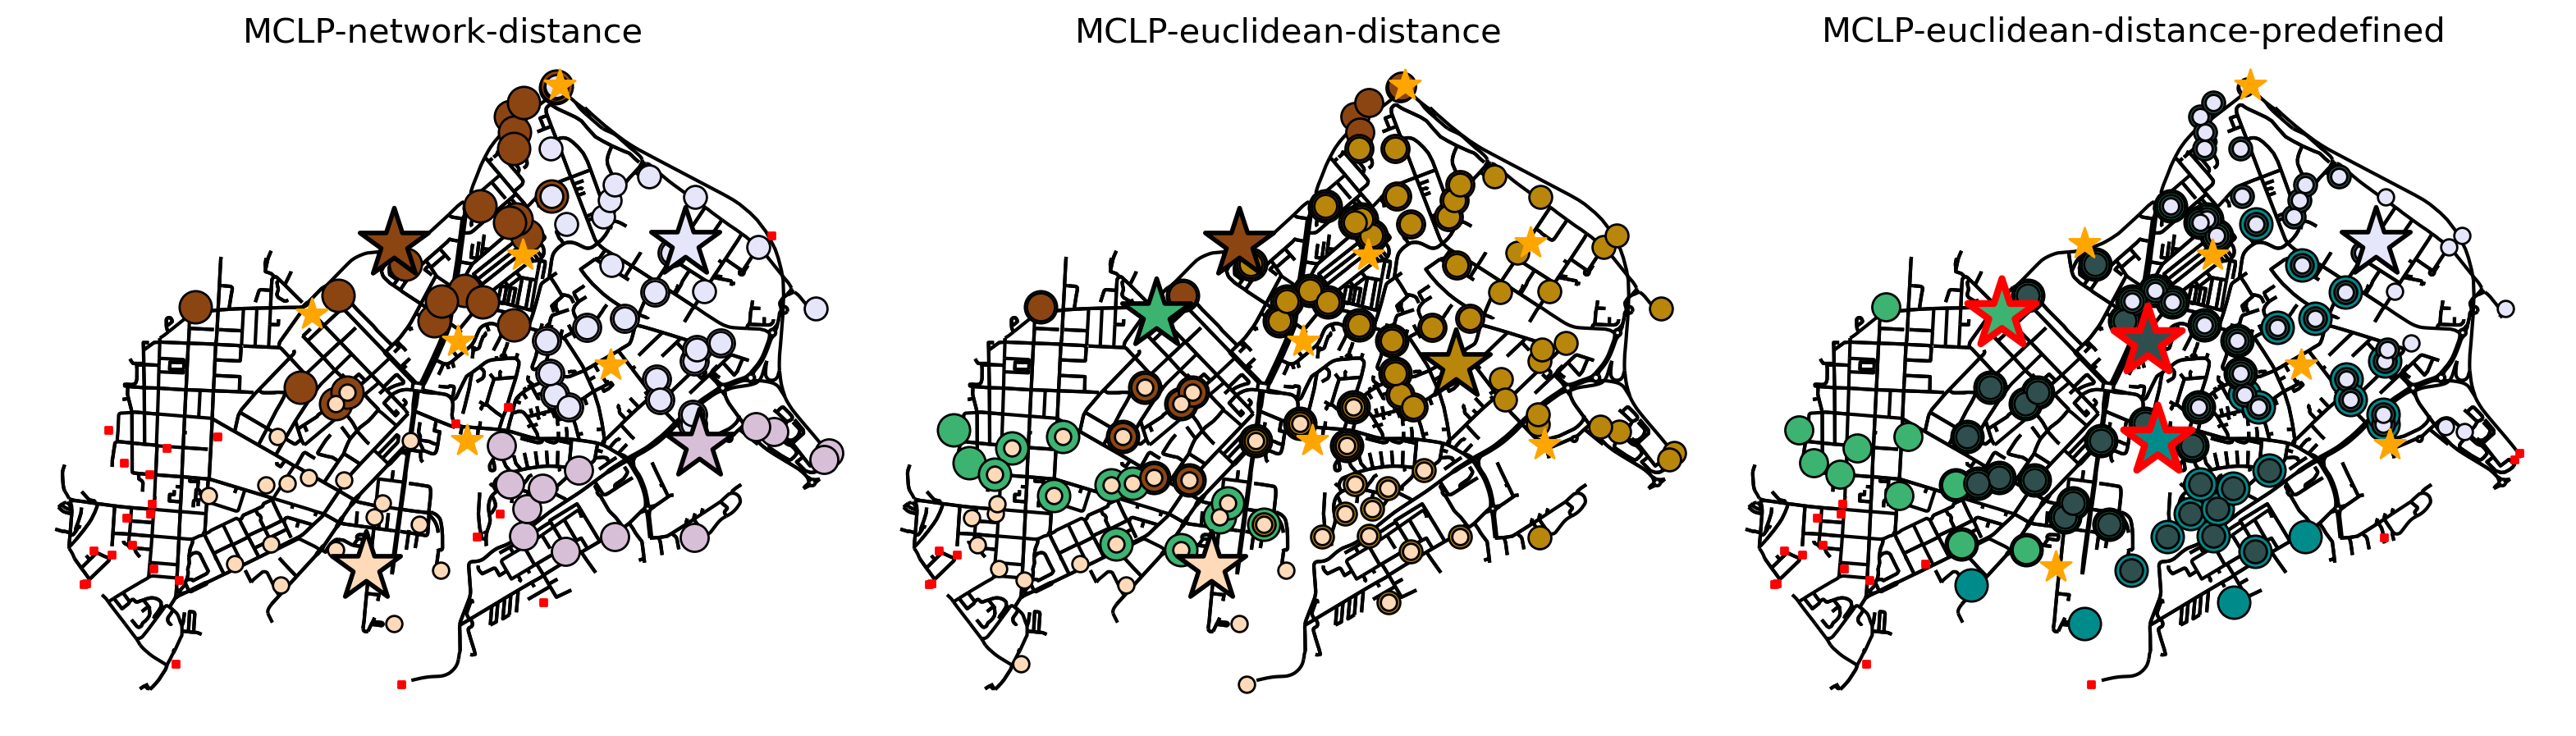

In [173]:
fig, axarr = plt.subplots(1, 3, figsize=(20, 10))
fig.subplots_adjust(wspace=-0.01)
for i, m in enumerate([mclp_from_cm, mclp_from_gdf, mclp_from_gdf_pre]):
    plot_results(m, P_FACILITIES, facility_points, clis=client_points, ax=axarr[i])

## References

- [Church, R. L., & Murray, A. T. (2018). Location covering models: History, applications and advancements (1st edition 2018). Springer](https://www.springer.com/gb/book/9783319998459)